In [8]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score, cross_val_predict
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler, label_binarize, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import RFE, chi2, mutual_info_classif, f_classif, SelectKBest, SequentialFeatureSelector
from imblearn.over_sampling import SMOTE
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from scikeras.wrappers import KerasClassifier
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import shap
import lime
import lime.lime_tabular
from lime.lime_tabular import LimeTabularExplainer

from utils import calculate_evaluation_metrics, display_shap_plot, display_lime_plot, plot_class_probability_distributions, get_selected_features

In [2]:
def create_model(input_dim, num_classes=2, hidden_layers=[64], activation='relu', optimizer='adam', **kwargs):
    model = Sequential()
    
    model.add(Dense(hidden_layers[0], input_dim=input_dim, activation=activation))
    
    for units in hidden_layers[1:]:
        model.add(Dense(units, activation=activation))
    
    if num_classes == 2:
        model.add(Dense(1, activation='sigmoid'))
        loss = 'binary_crossentropy'
    else:
        model.add(Dense(num_classes, activation='softmax'))
        loss = 'sparse_categorical_crossentropy'
    
    model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])
    
    return model

In [5]:
def display_shap_lime_plots_for_keras(keras_model, X_train, X_test, index, feature_names, class_names):
    X_train_df = pd.DataFrame(X_train, columns=feature_names)
    X_test_df = pd.DataFrame(X_test, columns=feature_names)

    explainer = shap.Explainer(keras_model.predict, X_train_df)
    shap_values = explainer(X_test_df)

    shap.summary_plot(shap_values, X_test_df, plot_type="bar")

    lime_explainer = LimeTabularExplainer(
        training_data=X_train_df.values,
        feature_names=feature_names,
        class_names=class_names,
        mode='classification'
    )

    exp = lime_explainer.explain_instance(
        data_row=X_test_df.iloc[index].values,
        predict_fn=keras_model.predict
    )
    exp.as_pyplot_figure()
    plt.show()


<h3>Classification results, input: statistics from the <b>first 5</b> seasons</h3>

In [61]:
df_5 = pd.read_csv('data/final_dataset_5_seasons.csv', low_memory=False)

class_mapping = {'bench': 0, 'starter': 1, 'all-star': 2}
df_5['Player_class_num'] = df_5['Player_class'].map(class_mapping)

final_dataset_5_seasons = df_5[get_selected_features(5)]

X = final_dataset_5_seasons.drop(columns=['Player_class_num'])
y = final_dataset_5_seasons['Player_class_num']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


=== Classification Report ===
               precision    recall  f1-score   support

           0       0.70      0.78      0.74        88
           1       0.62      0.52      0.57        75
           2       0.68      0.73      0.70        26

    accuracy                           0.67       189
   macro avg       0.67      0.68      0.67       189
weighted avg       0.67      0.67      0.67       189


=== ROC AUC and PR AUC values ===
ROC AUC: 0.8789455010261795
PR AUC: 0.8046138263110899


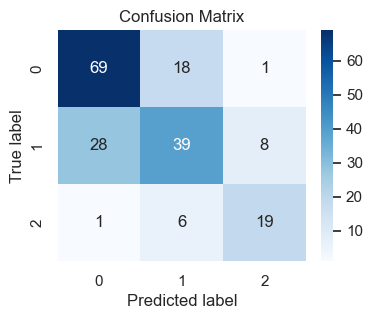

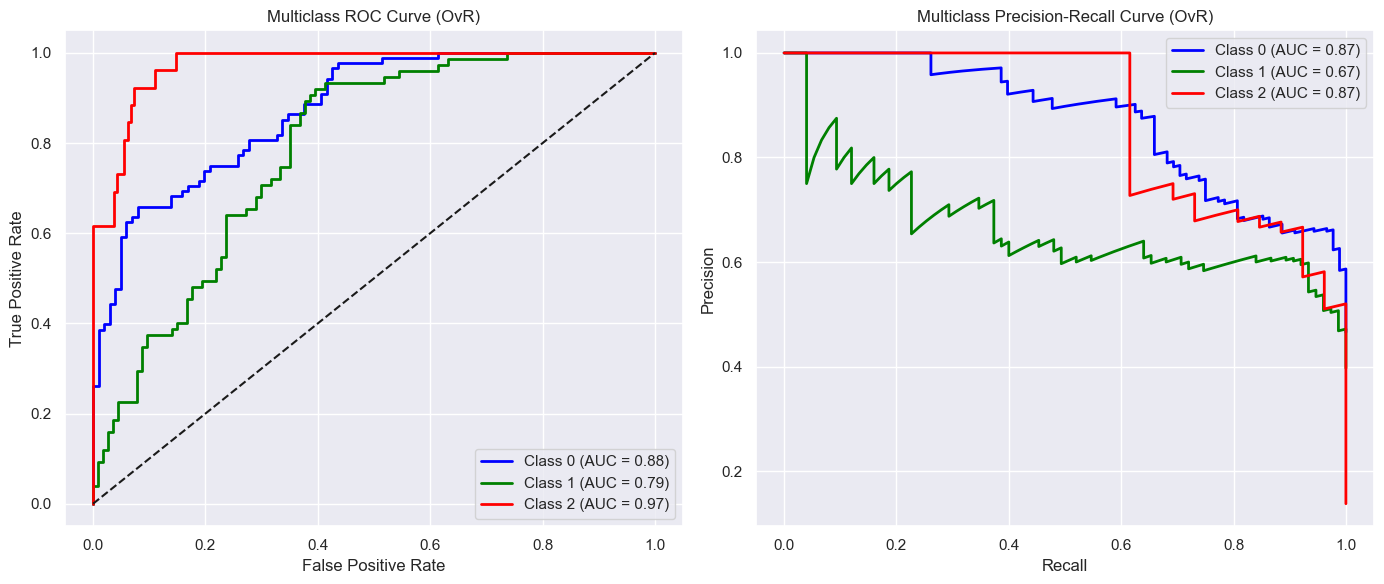


Binary classification results: all-star vs. others


=== Classification Report ===
               precision    recall  f1-score   support

           0       0.97      0.85      0.91       163
           1       0.48      0.85      0.61        26

    accuracy                           0.85       189
   macro avg       0.73      0.85      0.76       189
weighted avg       0.90      0.85      0.87       189


=== ROC AUC and PR AUC values ===
ROC AUC: 0.9365266635205285
PR AUC: 0.683758556525426


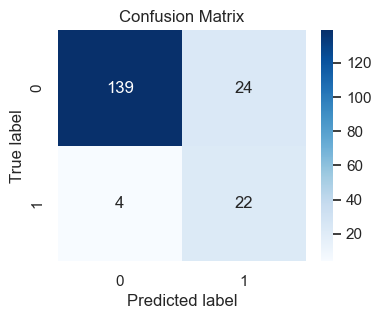

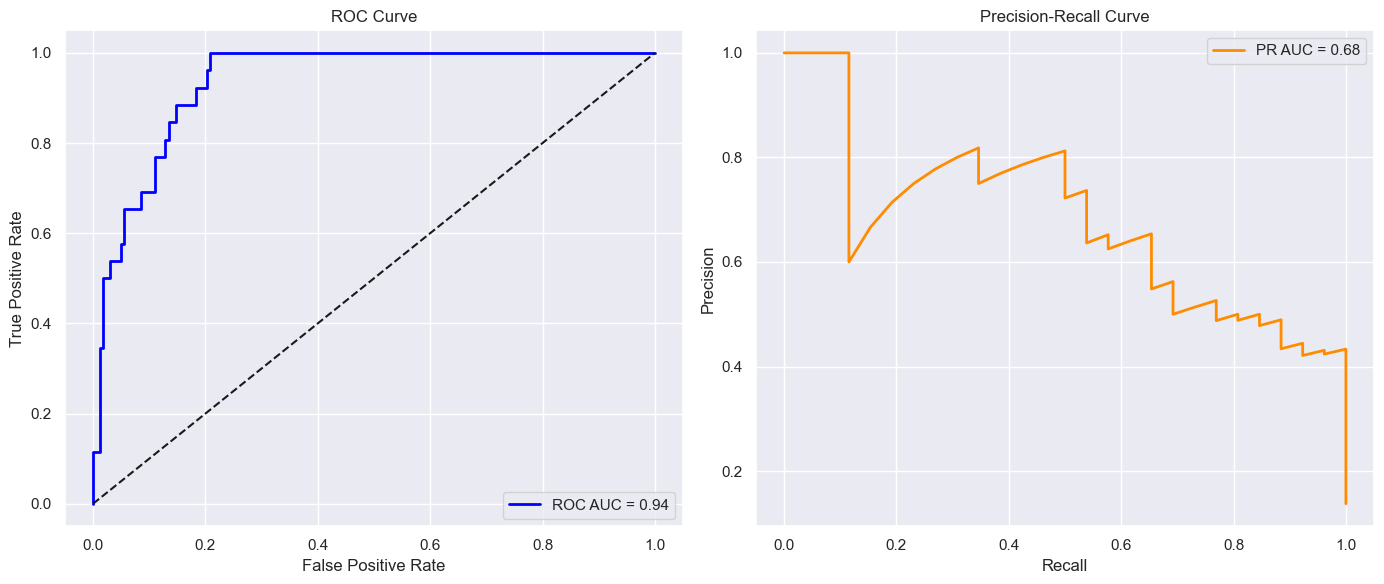


Binary classification results: starter vs. others


=== Classification Report ===
               precision    recall  f1-score   support

           0       0.80      0.69      0.74       114
           1       0.61      0.73      0.67        75

    accuracy                           0.71       189
   macro avg       0.70      0.71      0.70       189
weighted avg       0.72      0.71      0.71       189


=== ROC AUC and PR AUC values ===
ROC AUC: 0.7879532163742691
PR AUC: 0.6537349433918369


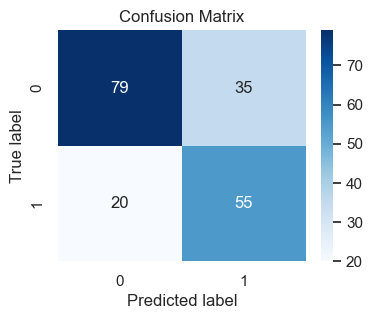

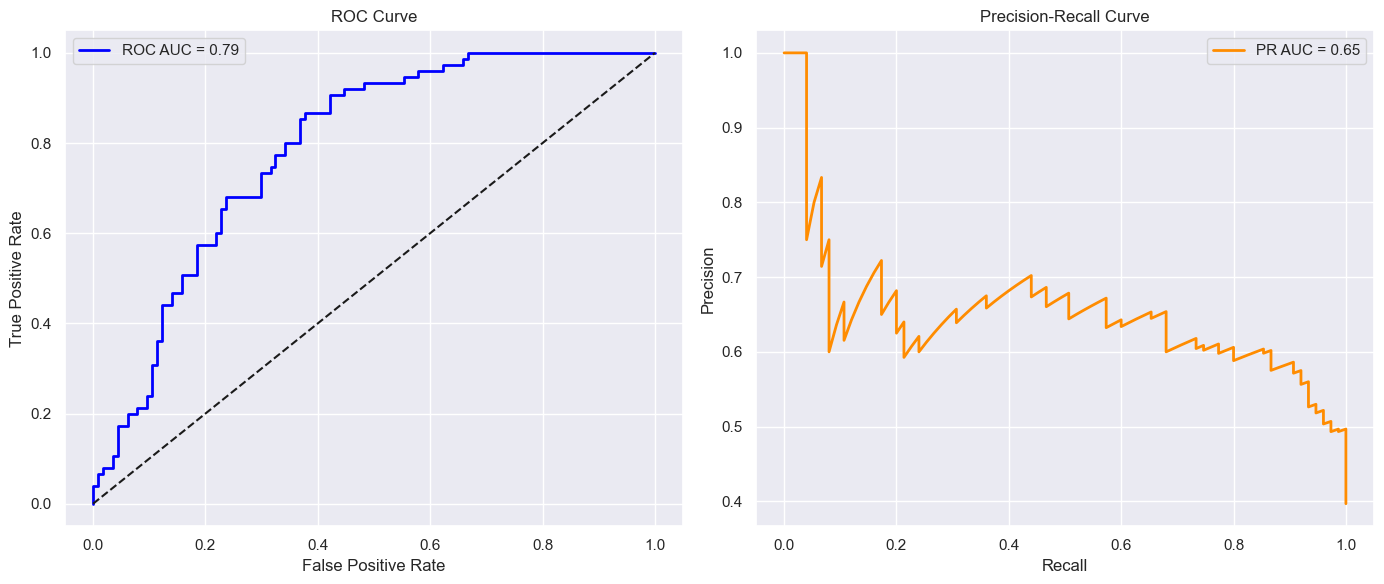


Binary classification results: bench vs. others


=== Classification Report ===
               precision    recall  f1-score   support

           0       0.86      0.82      0.84       101
           1       0.81      0.85      0.83        88

    accuracy                           0.84       189
   macro avg       0.84      0.84      0.84       189
weighted avg       0.84      0.84      0.84       189


=== ROC AUC and PR AUC values ===
ROC AUC: 0.8985148514851485
PR AUC: 0.8761440464118788


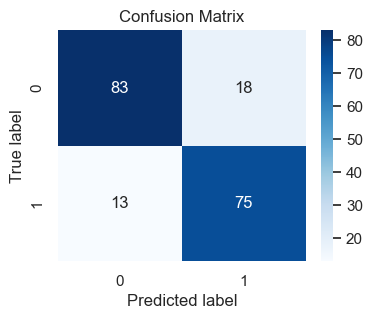

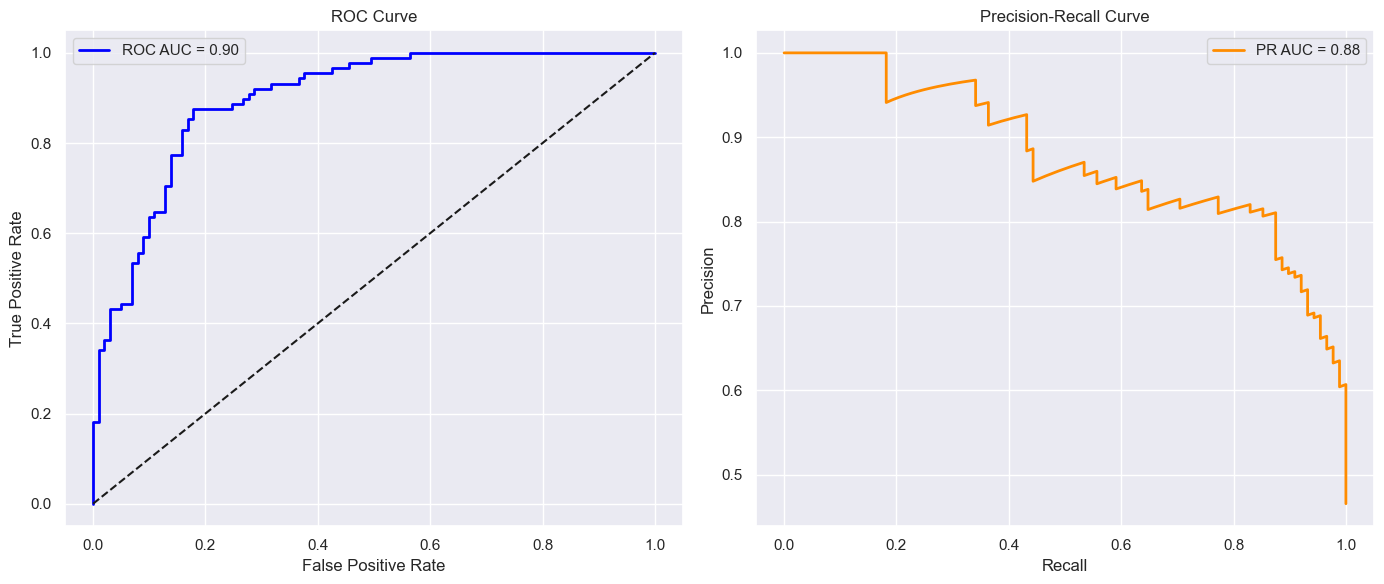

In [66]:
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = dict(zip(np.unique(y_train), class_weights))

keras_clf = KerasClassifier(
    model=create_model,
    verbose=0,
    input_dim=X_train.shape[1],
    num_classes=num_classes,
    optimizer='adam',
    activation='tanh',
    hidden_layers=[300],
    batch_size=32,
    epochs=100,
    random_state=42
)

keras_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', keras_clf)
])

keras_pipeline.fit(X_train, y_train, clf__class_weight=class_weights)

X_test_scaled = keras_pipeline.named_steps['scaler'].transform(X_test)
y_pred_proba = keras_pipeline.named_steps['clf'].predict_proba(X_test_scaled)
y_pred = np.argmax(y_pred_proba, axis=1)

calculate_evaluation_metrics(keras_pipeline.named_steps['clf'].model_, y_test, y_pred, y_pred_proba)

for class_num, class_label in zip([2, 1, 0], ["all-star", "starter", "bench"]):
    df_bin = final_dataset_5_seasons.copy()
    df_bin[f'{class_label}_class'] = df_bin['Player_class_num'].apply(lambda x: 1 if x == class_num else 0)

    X_bin = df_bin.drop(columns=['Player_class_num', f'{class_label}_class'])
    y_bin = df_bin[f'{class_label}_class']

    X_train_bin, X_test_bin, y_train_bin, y_test_bin = train_test_split(
        X_bin, y_bin, test_size=0.2, random_state=42, stratify=y_bin)
    
    class_weights = compute_class_weight(
        class_weight='balanced',
        classes=np.unique(y_train_bin),
        y=y_train_bin
    )
    class_weights = dict(zip(np.unique(y_train_bin), class_weights))

    keras_clf_bin = KerasClassifier(
        model=create_model,
        verbose=0,
        input_dim=X_train_bin.shape[1],
        num_classes=num_classes_bin,
        optimizer='adam',
        activation='tanh',
        hidden_layers=[300],
        batch_size=32,
        epochs=100,
        random_state=42
    )

    keras_pipeline_bin = Pipeline([
        ('scaler', StandardScaler()),
        ('clf', keras_clf_bin)
    ])

    keras_pipeline_bin.fit(X_train_bin, y_train_bin, clf__class_weight=class_weights)

    X_test_scaled_bin = keras_pipeline_bin.named_steps['scaler'].transform(X_test_bin)
    y_pred_proba_bin = keras_pipeline_bin.named_steps['clf'].predict_proba(X_test_scaled_bin)
    y_pred_bin = np.argmax(y_pred_proba_bin, axis=1)
    
    print(f"\nBinary classification results: {class_label} vs. others\n")
    calculate_evaluation_metrics(keras_pipeline_bin.named_steps['clf'].model_, y_test_bin, y_pred_bin, y_pred_proba_bin)

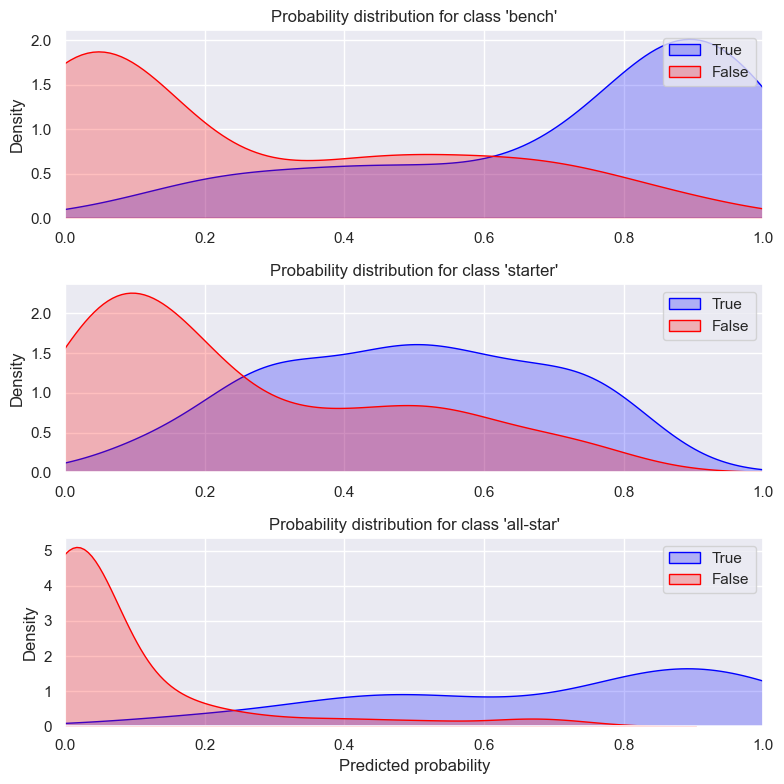

91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━

PermutationExplainer explainer:   1%|          | 2/189 [00:00<?, ?it/s]

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:   2%|▏         | 4/189 [00:24<12:27,  4.04s/it]

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:   3%|▎         | 5/189 [00:32<17:18,  5.64s/it]

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:   3%|▎         | 6/189 [00:40<19:44,  6.47s/it]

97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:   4%|▎         | 7/189 [00:50<22:44,  7.50s/it]

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:   4%|▍         | 8/189 [00:58<23:14,  7.71s/it]

91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:   5%|▍         | 9/189 [01:06<23:57,  7.98s/it]

91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:   5%|▌         | 10/189 [01:15<24:16,  8.13s/it]

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:   6%|▌         | 11/189 [01:24<24:46,  8.35s/it]

96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:   6%|▋         | 12/189 [01:33<25:43,  8.72s/it]

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:   7%|▋         | 13/189 [01:43<26:18,  8.97s/it]

91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:   7%|▋         | 14/189 [01:52<26:11,  8.98s/it]

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:   8%|▊         | 15/189 [02:00<25:12,  8.69s/it]

96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:   8%|▊         | 16/189 [02:10<26:22,  9.15s/it]

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:   9%|▉         | 17/189 [02:18<25:00,  8.72s/it]

96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  10%|▉         | 18/189 [02:27<25:45,  9.04s/it]

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:  10%|█         | 19/189 [02:36<25:34,  9.02s/it]

91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  11%|█         | 20/189 [02:44<24:29,  8.70s/it]

91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:  11%|█         | 21/189 [02:53<23:57,  8.56s/it]

91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:  12%|█▏        | 22/189 [03:01<23:44,  8.53s/it]

91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:  12%|█▏        | 23/189 [03:09<23:34,  8.52s/it]

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:  13%|█▎        | 24/189 [03:18<23:28,  8.53s/it]

96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  13%|█▎        | 25/189 [03:29<25:02,  9.16s/it]

91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:  14%|█▍        | 26/189 [03:37<24:27,  9.00s/it]

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:  14%|█▍        | 27/189 [03:46<24:03,  8.91s/it]

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:  15%|█▍        | 28/189 [03:55<23:54,  8.91s/it]

91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:  15%|█▌        | 29/189 [04:04<23:32,  8.83s/it]

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:  16%|█▌        | 30/189 [04:13<24:15,  9.15s/it]

96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:  16%|█▋        | 31/189 [04:23<24:12,  9.19s/it]

91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:  17%|█▋        | 32/189 [04:32<23:53,  9.13s/it]

91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:  17%|█▋        | 33/189 [04:40<22:56,  8.82s/it]

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:  18%|█▊        | 34/189 [04:49<23:16,  9.01s/it]

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:  19%|█▊        | 35/189 [04:58<23:03,  8.99s/it]

91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:  19%|█▉        | 36/189 [05:08<23:13,  9.11s/it]

91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:  20%|█▉        | 37/189 [05:17<23:21,  9.22s/it]

91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  20%|██        | 38/189 [05:26<22:49,  9.07s/it]

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:  21%|██        | 39/189 [05:35<22:41,  9.08s/it]

91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:  21%|██        | 40/189 [05:43<21:53,  8.82s/it]

91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:  22%|██▏       | 41/189 [05:52<21:55,  8.89s/it]

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:  22%|██▏       | 42/189 [06:00<21:09,  8.64s/it]

96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:  23%|██▎       | 43/189 [06:09<21:28,  8.82s/it]

91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:  23%|██▎       | 44/189 [06:18<20:50,  8.63s/it]

91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:  24%|██▍       | 45/189 [06:25<19:59,  8.33s/it]

96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:  24%|██▍       | 46/189 [06:34<20:16,  8.51s/it]

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:  25%|██▍       | 47/189 [06:43<20:14,  8.56s/it]

91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:  25%|██▌       | 48/189 [06:52<20:10,  8.59s/it]

91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:  26%|██▌       | 49/189 [07:00<19:55,  8.54s/it]

91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:  26%|██▋       | 50/189 [07:08<19:16,  8.32s/it]

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:  27%|██▋       | 51/189 [07:16<18:54,  8.22s/it]

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:  28%|██▊       | 52/189 [07:24<18:28,  8.09s/it]

91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  28%|██▊       | 53/189 [07:31<18:14,  8.04s/it]

91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:  29%|██▊       | 54/189 [07:40<18:14,  8.11s/it]

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:  29%|██▉       | 55/189 [07:48<18:24,  8.25s/it]

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:  30%|██▉       | 56/189 [07:56<18:10,  8.20s/it]

91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:  30%|███       | 57/189 [08:05<18:16,  8.31s/it]

91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:  31%|███       | 58/189 [08:13<18:02,  8.26s/it]

91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  31%|███       | 59/189 [08:21<17:40,  8.16s/it]

91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:  32%|███▏      | 60/189 [08:29<17:16,  8.04s/it]

91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:  32%|███▏      | 61/189 [08:38<17:42,  8.30s/it]

91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:  33%|███▎      | 62/189 [08:47<18:00,  8.51s/it]

96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:  33%|███▎      | 63/189 [08:57<19:04,  9.08s/it]

91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:  34%|███▍      | 64/189 [09:06<18:50,  9.04s/it]

91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:  34%|███▍      | 65/189 [09:14<18:14,  8.83s/it]

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:  35%|███▍      | 66/189 [09:22<17:36,  8.59s/it]

91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:  35%|███▌      | 67/189 [09:32<18:19,  9.01s/it]

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:  36%|███▌      | 68/189 [09:43<18:51,  9.35s/it]

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  37%|███▋      | 69/189 [09:51<18:06,  9.05s/it]

91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:  37%|███▋      | 70/189 [10:00<17:49,  8.99s/it]

96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:  38%|███▊      | 71/189 [10:09<17:44,  9.02s/it]

91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:  38%|███▊      | 72/189 [10:17<17:09,  8.80s/it]

97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:  39%|███▊      | 73/189 [10:25<16:41,  8.63s/it]

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:  39%|███▉      | 74/189 [10:34<16:28,  8.60s/it]

96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:  40%|███▉      | 75/189 [10:44<17:01,  8.96s/it]

91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:  40%|████      | 76/189 [10:52<16:16,  8.64s/it]

91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:  41%|████      | 77/189 [11:00<15:51,  8.49s/it]

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:  41%|████▏     | 78/189 [11:08<15:47,  8.54s/it]

91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:  42%|████▏     | 79/189 [11:16<15:18,  8.35s/it]

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:  42%|████▏     | 80/189 [11:24<15:01,  8.27s/it]

97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:  43%|████▎     | 81/189 [11:33<15:03,  8.36s/it]

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:  43%|████▎     | 82/189 [11:41<14:51,  8.33s/it]

97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:  44%|████▍     | 83/189 [11:51<15:25,  8.73s/it]

91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:  44%|████▍     | 84/189 [11:59<14:56,  8.54s/it]

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:  45%|████▍     | 85/189 [12:08<15:02,  8.68s/it]

96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:  46%|████▌     | 86/189 [12:18<15:39,  9.12s/it]

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:  46%|████▌     | 87/189 [12:27<15:29,  9.11s/it]

91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:  47%|████▋     | 88/189 [12:35<14:45,  8.77s/it]

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  47%|████▋     | 89/189 [12:44<14:26,  8.66s/it]

91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:  48%|████▊     | 90/189 [12:52<14:01,  8.50s/it]

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:  48%|████▊     | 91/189 [13:00<13:42,  8.39s/it]

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:  49%|████▊     | 92/189 [13:08<13:23,  8.28s/it]

91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:  49%|████▉     | 93/189 [13:16<12:57,  8.10s/it]

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:  50%|████▉     | 94/189 [13:25<13:14,  8.36s/it]

96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:  50%|█████     | 95/189 [13:33<13:01,  8.31s/it]

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:  51%|█████     | 96/189 [13:41<13:02,  8.41s/it]

91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:  51%|█████▏    | 97/189 [13:50<12:53,  8.41s/it]

91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:  52%|█████▏    | 98/189 [13:58<12:41,  8.37s/it]

96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:  52%|█████▏    | 99/189 [14:07<12:49,  8.55s/it]

91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:  53%|█████▎    | 100/189 [14:15<12:17,  8.29s/it]

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:  53%|█████▎    | 101/189 [14:22<11:55,  8.13s/it]

97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:  54%|█████▍    | 102/189 [14:31<11:50,  8.17s/it]

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:  54%|█████▍    | 103/189 [14:39<11:52,  8.28s/it]

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:  55%|█████▌    | 104/189 [14:48<11:43,  8.28s/it]

95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  56%|█████▌    | 105/189 [14:57<12:04,  8.62s/it]

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:  56%|█████▌    | 106/189 [15:05<11:49,  8.55s/it]

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:  57%|█████▋    | 107/189 [15:14<11:37,  8.51s/it]

91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:  57%|█████▋    | 108/189 [15:22<11:22,  8.43s/it]

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  58%|█████▊    | 109/189 [15:30<10:58,  8.24s/it]

91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  58%|█████▊    | 110/189 [15:38<10:40,  8.11s/it]

91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:  59%|█████▊    | 111/189 [15:46<10:38,  8.19s/it]

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:  59%|█████▉    | 112/189 [15:54<10:23,  8.10s/it]

91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:  60%|█████▉    | 113/189 [16:02<10:20,  8.17s/it]

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:  60%|██████    | 114/189 [16:11<10:24,  8.32s/it]

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:  61%|██████    | 115/189 [16:19<10:05,  8.19s/it]

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:  61%|██████▏   | 116/189 [16:27<10:10,  8.36s/it]

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:  62%|██████▏   | 117/189 [16:37<10:22,  8.65s/it]

91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:  62%|██████▏   | 118/189 [16:46<10:18,  8.71s/it]

91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:  63%|██████▎   | 119/189 [16:54<09:52,  8.46s/it]

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:  63%|██████▎   | 120/189 [17:02<09:52,  8.58s/it]

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:  64%|██████▍   | 121/189 [17:11<09:52,  8.72s/it]

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:  65%|██████▍   | 122/189 [17:20<09:37,  8.62s/it]

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:  65%|██████▌   | 123/189 [17:28<09:26,  8.59s/it]

97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:  66%|██████▌   | 124/189 [17:38<09:39,  8.91s/it]

91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:  66%|██████▌   | 125/189 [17:46<09:09,  8.58s/it]

91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:  67%|██████▋   | 126/189 [17:54<08:59,  8.56s/it]

91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


PermutationExplainer explainer:  67%|██████▋   | 127/189 [18:03<08:50,  8.56s/it]

91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:  68%|██████▊   | 128/189 [18:11<08:28,  8.33s/it]

91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:  68%|██████▊   | 129/189 [18:19<08:17,  8.30s/it]

96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:  69%|██████▉   | 130/189 [18:28<08:31,  8.67s/it]

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:  69%|██████▉   | 131/189 [18:37<08:28,  8.77s/it]

91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:  70%|██████▉   | 132/189 [18:46<08:16,  8.70s/it]

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  70%|███████   | 133/189 [18:55<08:11,  8.78s/it]

91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


PermutationExplainer explainer:  71%|███████   | 134/189 [19:05<08:22,  9.13s/it]

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


PermutationExplainer explainer:  71%|███████▏  | 135/189 [19:15<08:25,  9.36s/it]

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:  72%|███████▏  | 136/189 [19:23<08:00,  9.06s/it]

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  72%|███████▏  | 137/189 [19:32<07:45,  8.96s/it]

91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:  73%|███████▎  | 138/189 [19:40<07:29,  8.82s/it]

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


PermutationExplainer explainer:  74%|███████▎  | 139/189 [19:49<07:19,  8.80s/it]

97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:  74%|███████▍  | 140/189 [19:59<07:20,  8.99s/it]

91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:  75%|███████▍  | 141/189 [20:07<07:07,  8.91s/it]

91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:  75%|███████▌  | 142/189 [20:16<07:00,  8.94s/it]

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:  76%|███████▌  | 143/189 [20:26<06:58,  9.10s/it]

91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:  76%|███████▌  | 144/189 [20:34<06:35,  8.80s/it]

96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:  77%|███████▋  | 145/189 [20:44<06:50,  9.33s/it]

96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:  77%|███████▋  | 146/189 [20:55<06:54,  9.63s/it]

91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:  78%|███████▊  | 147/189 [21:03<06:25,  9.17s/it]

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:  78%|███████▊  | 148/189 [21:12<06:17,  9.21s/it]

91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  79%|███████▉  | 149/189 [21:21<06:09,  9.23s/it]

91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:  79%|███████▉  | 150/189 [21:29<05:41,  8.77s/it]

91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:  80%|███████▉  | 151/189 [21:38<05:34,  8.80s/it]

91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:  80%|████████  | 152/189 [21:47<05:22,  8.73s/it]

96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:  81%|████████  | 153/189 [21:57<05:34,  9.30s/it]

91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:  81%|████████▏ | 154/189 [22:06<05:18,  9.09s/it]

91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:  82%|████████▏ | 155/189 [22:15<05:06,  9.01s/it]

91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:  83%|████████▎ | 156/189 [22:23<04:54,  8.91s/it]

91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:  83%|████████▎ | 157/189 [22:31<04:38,  8.69s/it]

96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:  84%|████████▎ | 158/189 [22:42<04:43,  9.16s/it]

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:  84%|████████▍ | 159/189 [22:51<04:35,  9.18s/it]

91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  85%|████████▍ | 160/189 [23:01<04:29,  9.30s/it]

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  85%|████████▌ | 161/189 [23:10<04:24,  9.45s/it]

91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  86%|████████▌ | 162/189 [23:19<04:11,  9.30s/it]

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:  86%|████████▌ | 163/189 [23:28<03:58,  9.19s/it]

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  87%|████████▋ | 164/189 [23:37<03:49,  9.16s/it]

91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:  87%|████████▋ | 165/189 [23:45<03:30,  8.77s/it]

91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:  88%|████████▊ | 166/189 [23:53<03:16,  8.56s/it]

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:  88%|████████▊ | 167/189 [24:04<03:20,  9.13s/it]

91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:  89%|████████▉ | 168/189 [24:13<03:12,  9.15s/it]

91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  89%|████████▉ | 169/189 [24:22<03:04,  9.24s/it]

96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:  90%|████████▉ | 170/189 [24:31<02:54,  9.19s/it]

91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:  90%|█████████ | 171/189 [24:41<02:46,  9.26s/it]

91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:  91%|█████████ | 172/189 [24:50<02:34,  9.09s/it]

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  92%|█████████▏| 173/189 [24:59<02:25,  9.12s/it]

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:  92%|█████████▏| 174/189 [25:09<02:20,  9.35s/it]

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:  93%|█████████▎| 175/189 [25:17<02:06,  9.06s/it]

97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:  93%|█████████▎| 176/189 [25:26<01:58,  9.09s/it]

91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  94%|█████████▎| 177/189 [25:34<01:44,  8.69s/it]

96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  94%|█████████▍| 178/189 [25:43<01:35,  8.67s/it]

97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  95%|█████████▍| 179/189 [25:51<01:26,  8.68s/it]

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:  95%|█████████▌| 180/189 [26:00<01:17,  8.64s/it]

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:  96%|█████████▌| 181/189 [26:08<01:07,  8.42s/it]

96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:  96%|█████████▋| 182/189 [26:17<00:59,  8.53s/it]

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:  97%|█████████▋| 183/189 [26:25<00:50,  8.47s/it]

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:  97%|█████████▋| 184/189 [26:34<00:43,  8.68s/it]

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:  98%|█████████▊| 185/189 [26:42<00:34,  8.54s/it]

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:  98%|█████████▊| 186/189 [26:50<00:25,  8.43s/it]

96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  99%|█████████▉| 187/189 [26:59<00:16,  8.45s/it]

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:  99%|█████████▉| 188/189 [27:08<00:08,  8.57s/it]

97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer: 100%|██████████| 189/189 [27:17<00:00,  8.75s/it]

91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer: 190it [27:25,  8.76s/it]                         


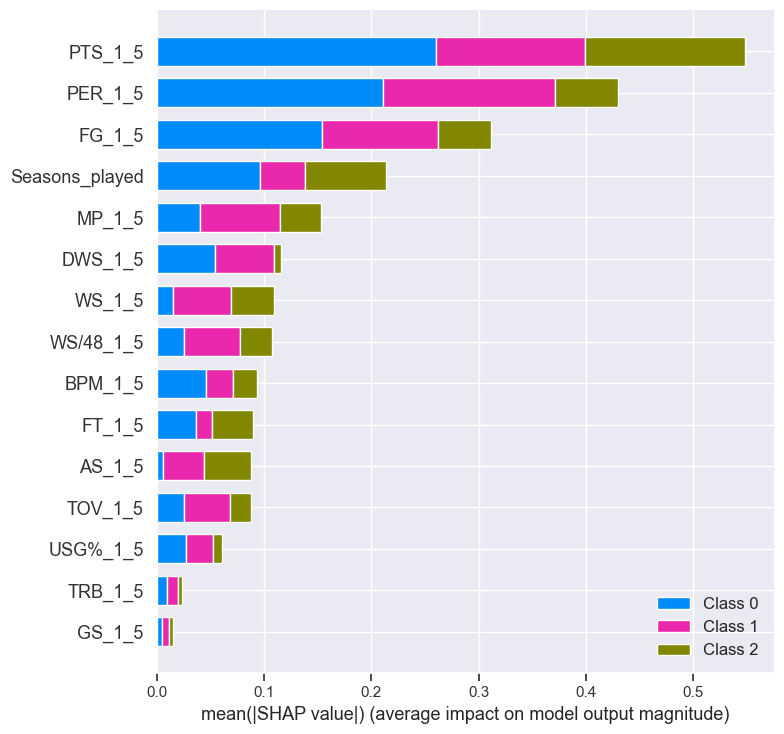

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


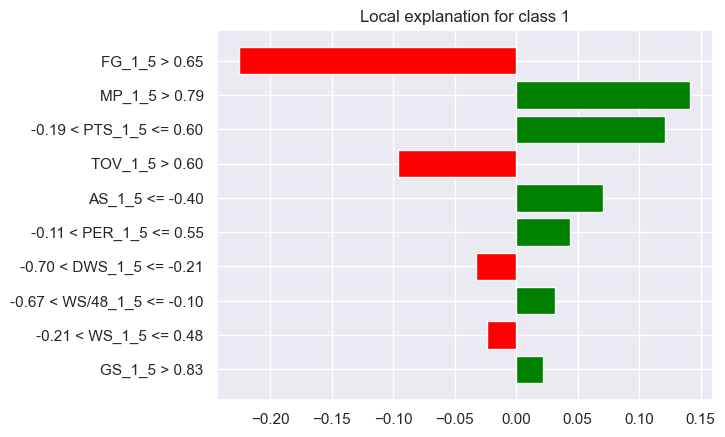

In [67]:
X_train_scaled_bin = keras_pipeline_bin.named_steps['scaler'].transform(X_train_bin)
plot_class_probability_distributions(y_test, y_pred_proba)
display_shap_lime_plots_for_keras(keras_pipeline.named_steps['clf'].model_, X_train_scaled, X_test_scaled, 0, feature_names = X_train.columns.tolist(),class_names=[str(i) for i in range(num_classes)])


=== Classification Report ===
               precision    recall  f1-score   support

           0       0.90      0.59      0.71        88
           1       0.58      0.76      0.66        75
           2       0.59      0.73      0.66        26

    accuracy                           0.68       189
   macro avg       0.69      0.69      0.67       189
weighted avg       0.73      0.68      0.68       189


=== ROC AUC and PR AUC values ===
ROC AUC: 0.8747094411551553
PR AUC: 0.774218738881871


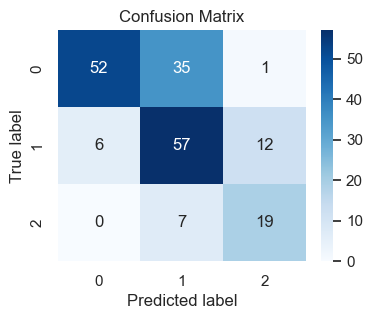

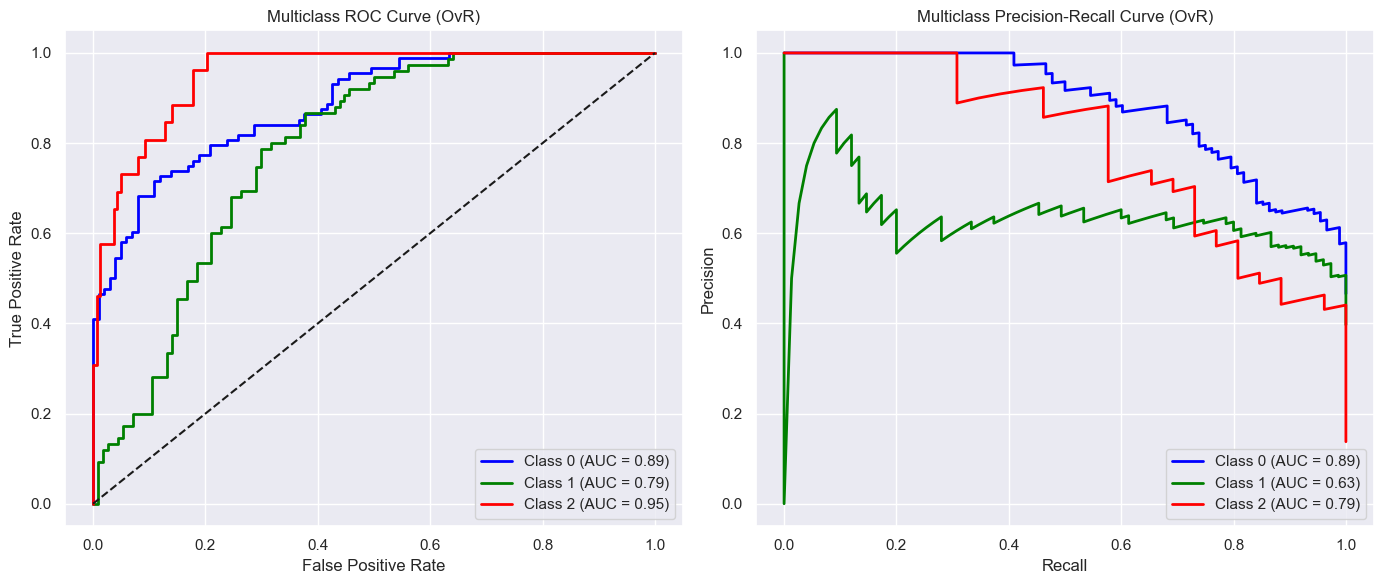


Binary classification results: all-star vs. others


=== Classification Report ===
               precision    recall  f1-score   support

           0       0.94      0.94      0.94       163
           1       0.65      0.65      0.65        26

    accuracy                           0.90       189
   macro avg       0.80      0.80      0.80       189
weighted avg       0.90      0.90      0.90       189


=== ROC AUC and PR AUC values ===
ROC AUC: 0.9365266635205285
PR AUC: 0.719065223549881


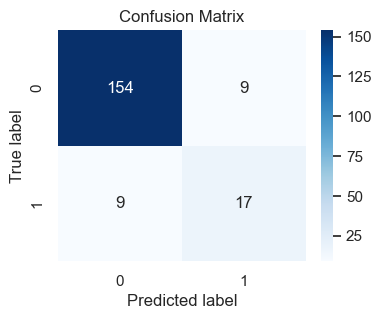

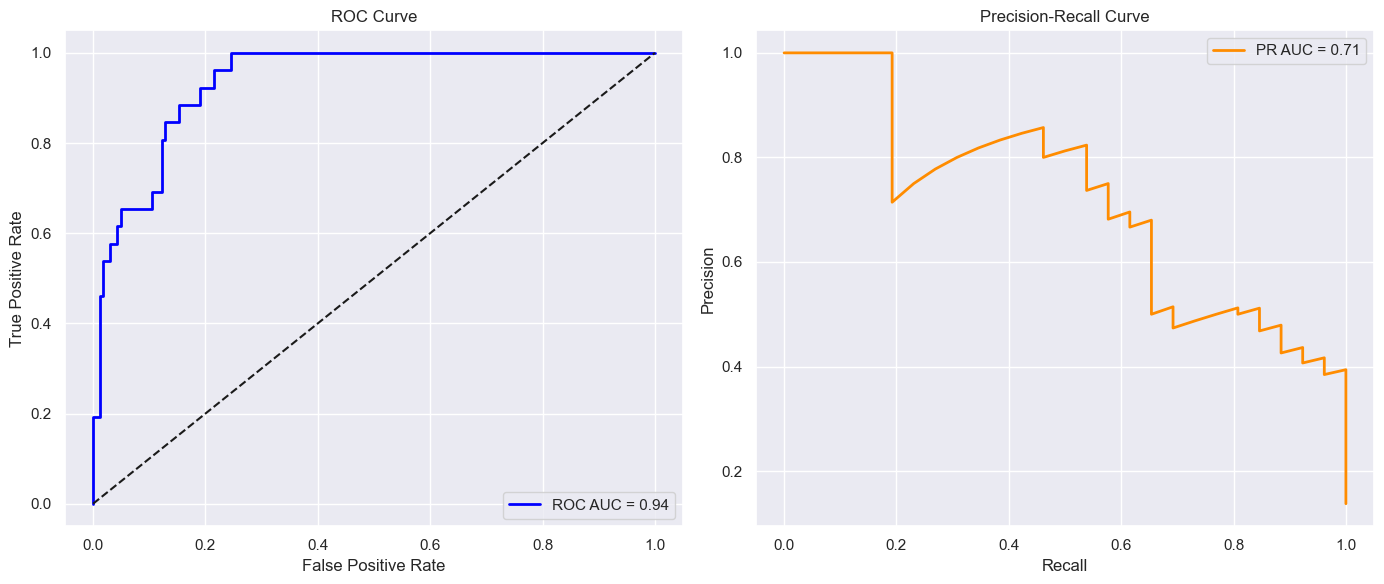


Binary classification results: starter vs. others


=== Classification Report ===
               precision    recall  f1-score   support

           0       0.76      0.77      0.77       114
           1       0.64      0.63      0.64        75

    accuracy                           0.71       189
   macro avg       0.70      0.70      0.70       189
weighted avg       0.71      0.71      0.71       189


=== ROC AUC and PR AUC values ===
ROC AUC: 0.7870175438596492
PR AUC: 0.6526411653817011


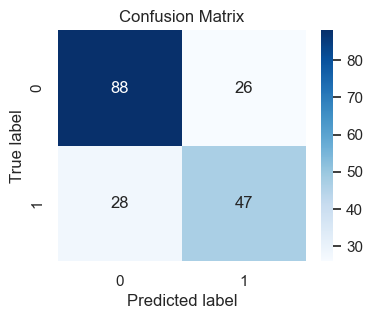

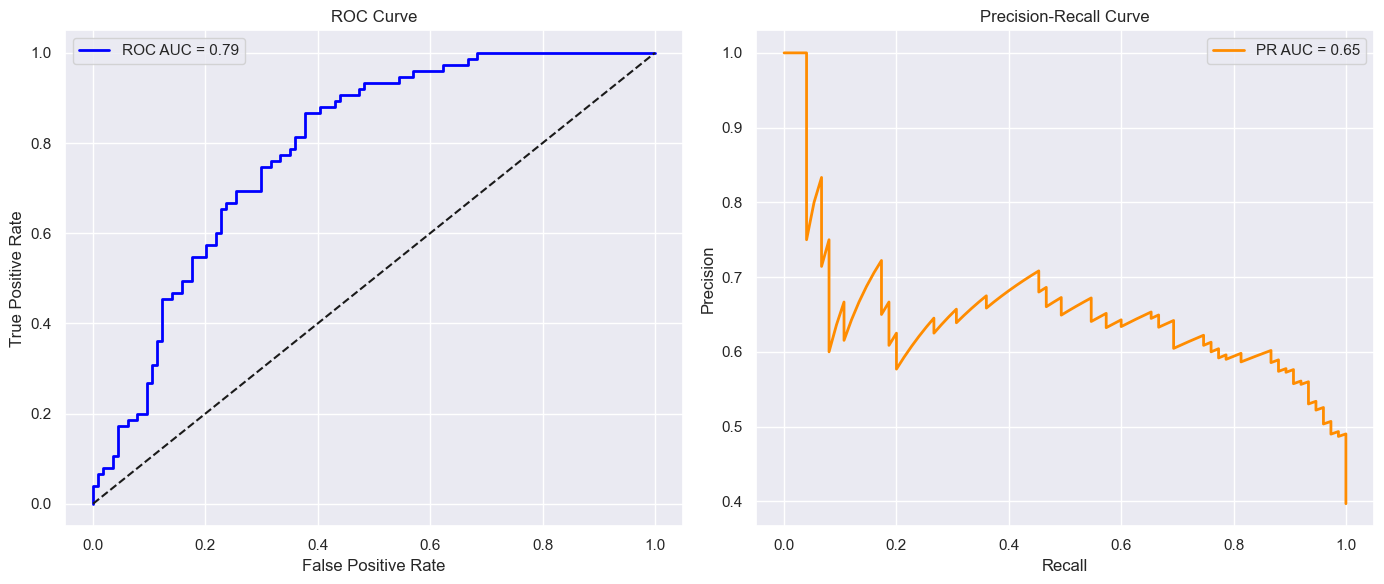


Binary classification results: bench vs. others


=== Classification Report ===
               precision    recall  f1-score   support

           0       0.84      0.84      0.84       101
           1       0.82      0.82      0.82        88

    accuracy                           0.83       189
   macro avg       0.83      0.83      0.83       189
weighted avg       0.83      0.83      0.83       189


=== ROC AUC and PR AUC values ===
ROC AUC: 0.8981773177317732
PR AUC: 0.8760479991338209


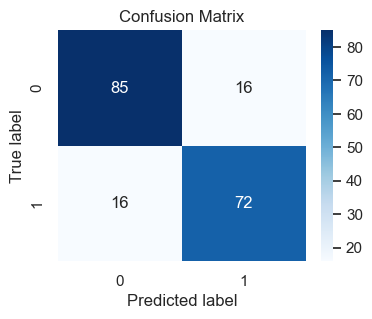

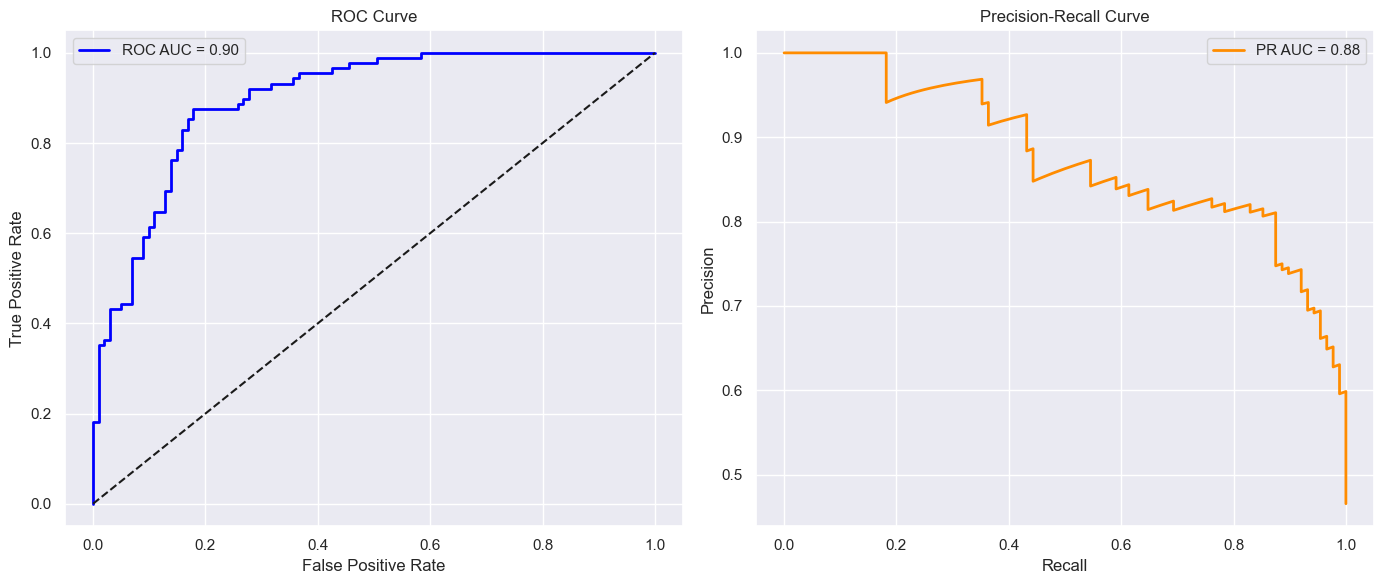

In [36]:
keras_clf = KerasClassifier(
    model=create_model,
    verbose=0,
    model__input_dim=X_train.shape[1],
    model__num_classes=num_classes,
    model__optimizer='adam',
    model__activation='tanh',
    model__hidden_layers=[300],
    batch_size=32,
    epochs=100,
    random_state=42
)

keras_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', keras_clf)
])
ovr = OneVsRestClassifier(keras_pipeline.named_steps['clf'])
ovr.fit(X_train, y_train)

y_pred_proba = ovr.predict_proba(X_test)

custom_preds = []
for probs in y_pred_proba:
    if probs[2] >= 0.25:        
        custom_preds.append(2)
    elif probs[1] >= 0.35:      
        custom_preds.append(1)
    else:
        custom_preds.append(0) 
        
y_pred_proba = y_pred_proba / y_pred_proba.sum(axis=1, keepdims=True)

calculate_evaluation_metrics(ovr, y_test, custom_preds, y_pred_proba)

for class_num, class_label in zip([2, 1, 0], ["all-star", "starter", "bench"]):
    df_bin = final_dataset_5_seasons.copy()
    df_bin[f'{class_label}_class'] = df_bin['Player_class_num'].apply(lambda x: 1 if x == class_num else 0)

    X_bin = df_bin.drop(columns=['Player_class_num', f'{class_label}_class'])
    y_bin = df_bin[f'{class_label}_class']

    X_train_bin, X_test_bin, y_train_bin, y_test_bin = train_test_split(
        X_bin, y_bin, test_size=0.2, random_state=42, stratify=y_bin)
    
    num_classes_bin = len(np.unique(y_train_bin))

    keras_clf_bin = KerasClassifier(
        model=create_model,
        verbose=0,
        input_dim=X_train_bin.shape[1],
        num_classes=num_classes_bin,
        optimizer='adam',
        activation='tanh',
        hidden_layers=[300],
        batch_size=32,
        epochs=100,
        random_state=42
    )

    keras_pipeline_bin = Pipeline([
        ('scaler', StandardScaler()),
        ('clf', keras_clf_bin)
    ])

    keras_pipeline_bin.fit(X_train_bin, y_train_bin)

    X_test_scaled_bin = keras_pipeline_bin.named_steps['scaler'].transform(X_test_bin)
    y_pred_proba_bin = keras_pipeline_bin.named_steps['clf'].predict_proba(X_test_scaled_bin)
    y_pred_bin = np.argmax(y_pred_proba_bin, axis=1)
    
    print(f"\nBinary classification results: {class_label} vs. others\n")
    calculate_evaluation_metrics(keras_pipeline_bin.named_steps['clf'].model_, y_test_bin, y_pred_bin, y_pred_proba_bin)

Number of elements in each class:
Player_class_num
0    351
1    300
2    102
Name: count, dtype: int64

Number of elements in each class after sampling:
Player_class_num
1    351
0    351
2    351
Name: count, dtype: int64

=== Classification Report ===
               precision    recall  f1-score   support

           0       0.72      0.77      0.75        88
           1       0.61      0.60      0.60        75
           2       0.76      0.62      0.68        26

    accuracy                           0.68       189
   macro avg       0.70      0.66      0.68       189
weighted avg       0.68      0.68      0.68       189


=== ROC AUC and PR AUC values ===
ROC AUC: 0.8791292989362024
PR AUC: 0.7970563517652507


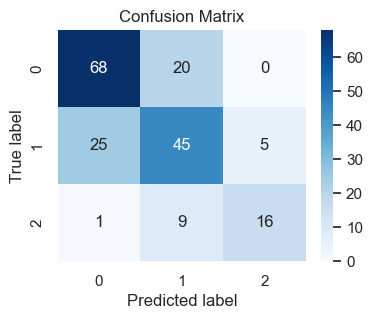

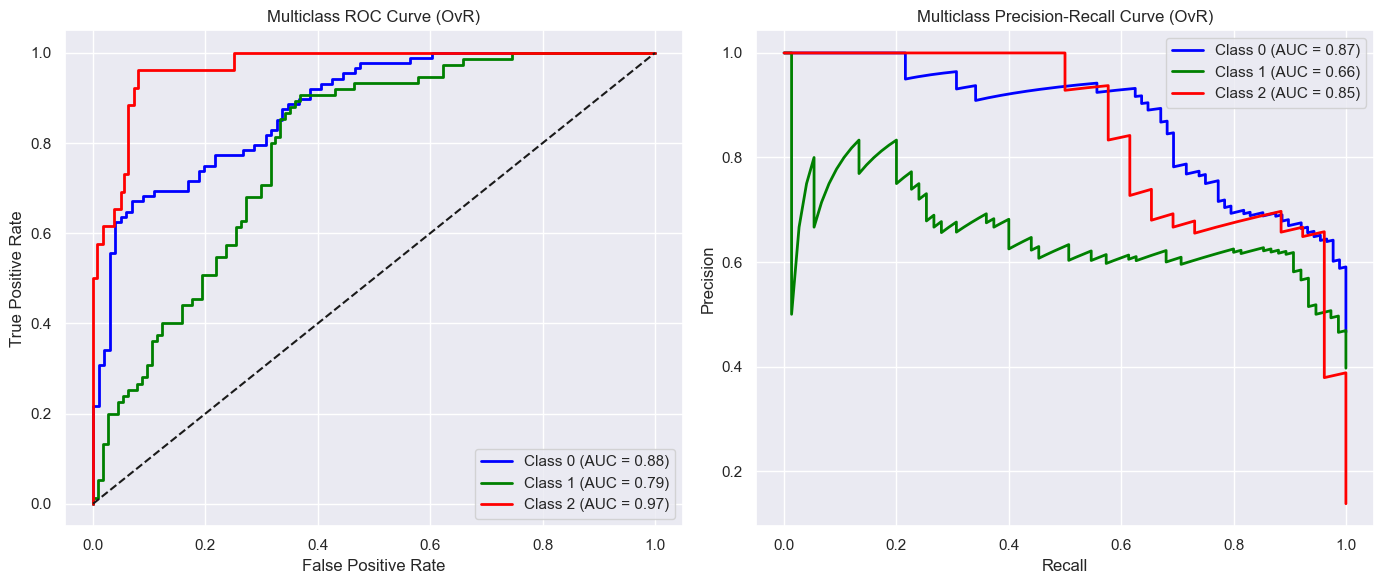

Number of elements in each class:
Player_class_num
0    351
1    300
2    102
Name: count, dtype: int64

Number of elements in each class after sampling:
all-star_class
0    651
1    651
Name: count, dtype: int64

Binary classification results: all-star vs. others


=== Classification Report ===
               precision    recall  f1-score   support

           0       0.95      0.87      0.90       163
           1       0.45      0.69      0.55        26

    accuracy                           0.84       189
   macro avg       0.70      0.78      0.72       189
weighted avg       0.88      0.84      0.85       189


=== ROC AUC and PR AUC values ===
ROC AUC: 0.9204813591316658
PR AUC: 0.662780625981997


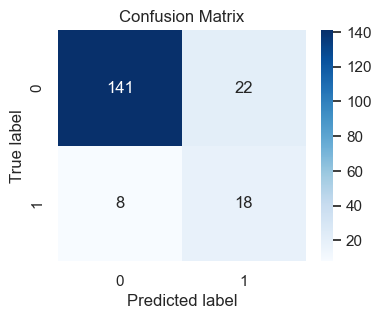

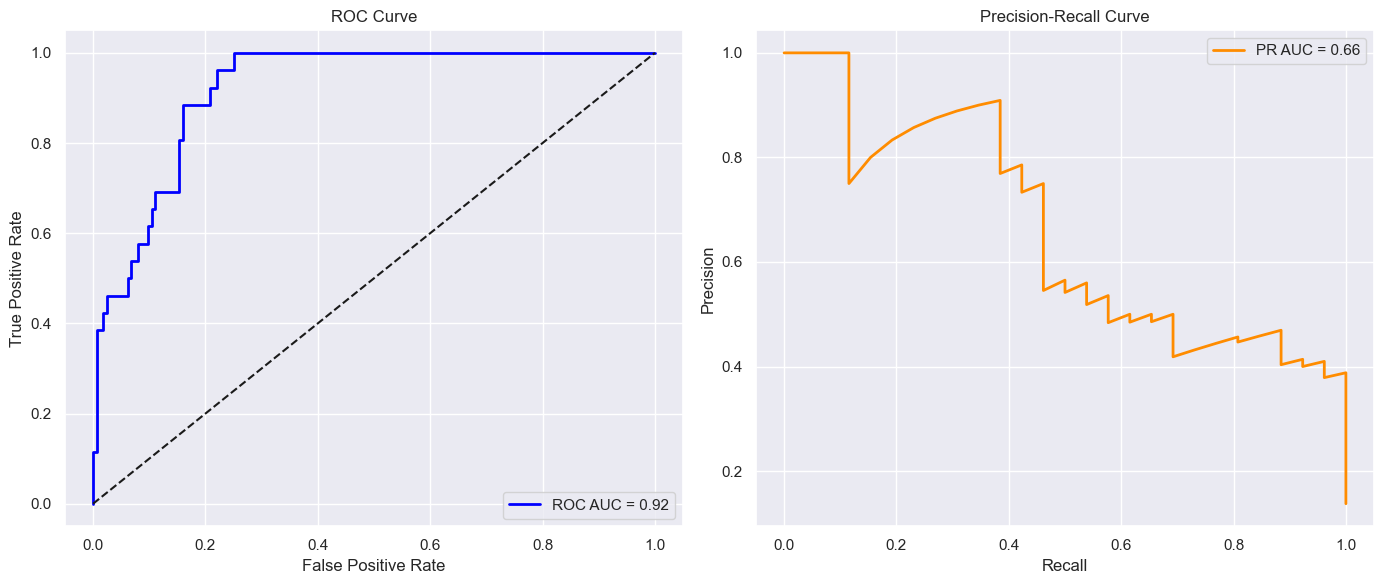

Number of elements in each class:
Player_class_num
0    351
1    300
2    102
Name: count, dtype: int64

Number of elements in each class after sampling:
starter_class
1    453
0    453
Name: count, dtype: int64

Binary classification results: starter vs. others


=== Classification Report ===
               precision    recall  f1-score   support

           0       0.77      0.69      0.73       114
           1       0.60      0.69      0.64        75

    accuracy                           0.69       189
   macro avg       0.69      0.69      0.69       189
weighted avg       0.70      0.69      0.70       189


=== ROC AUC and PR AUC values ===
ROC AUC: 0.7945029239766082
PR AUC: 0.661029332306043


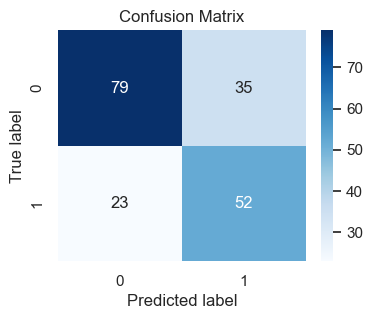

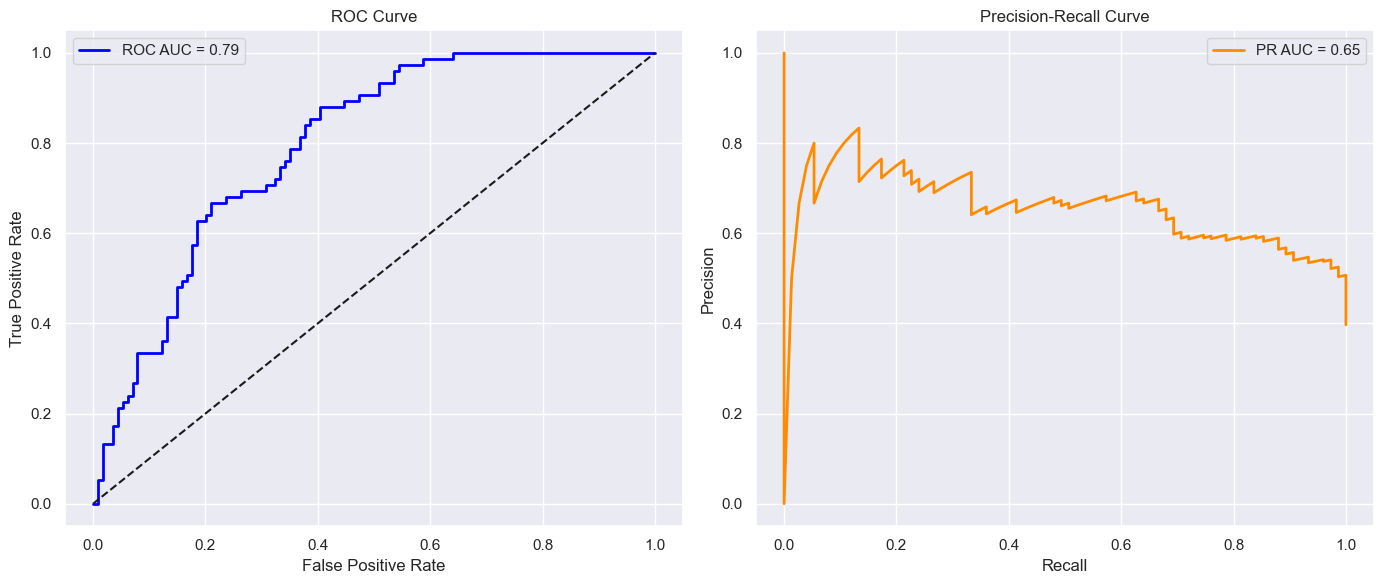

Number of elements in each class:
Player_class_num
0    351
1    300
2    102
Name: count, dtype: int64

Number of elements in each class after sampling:
bench_class
1    402
0    402
Name: count, dtype: int64

Binary classification results: bench vs. others


=== Classification Report ===
               precision    recall  f1-score   support

           0       0.86      0.83      0.84       101
           1       0.81      0.84      0.83        88

    accuracy                           0.84       189
   macro avg       0.84      0.84      0.84       189
weighted avg       0.84      0.84      0.84       189


=== ROC AUC and PR AUC values ===
ROC AUC: 0.8981773177317732
PR AUC: 0.8788427892731391


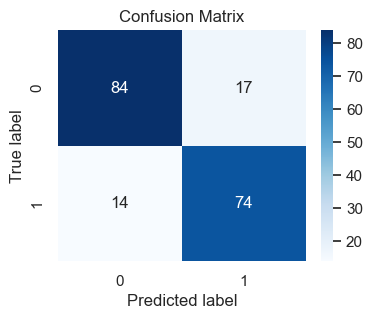

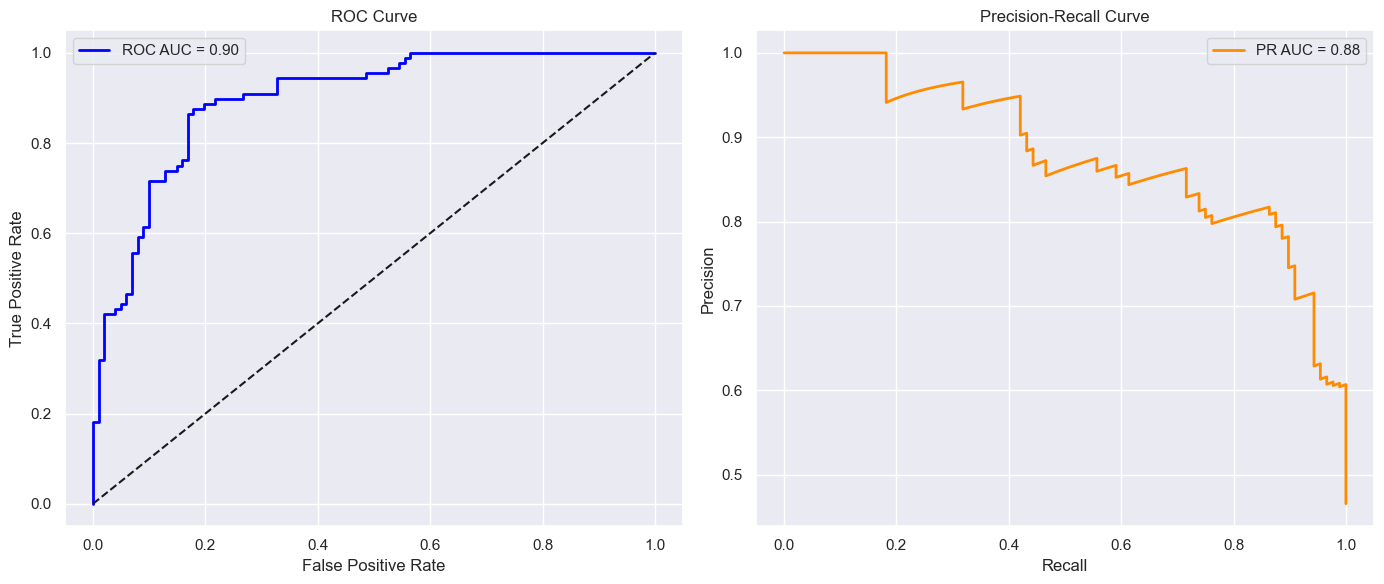

In [37]:
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X_train, y_train)

print('Number of elements in each class:')
print(y_train.value_counts())
print('\nNumber of elements in each class after sampling:')
print(pd.Series(y_res).value_counts())

num_classes = len(np.unique(y_res))

keras_clf = KerasClassifier(
    model=create_model,
    verbose=0,
    model__input_dim=X_res.shape[1],
    model__num_classes=num_classes,
    model__optimizer='adam',
    model__activation='tanh',
    model__hidden_layers=[300],
    batch_size=32,
    epochs=100,
    random_state=42
)

keras_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', keras_clf)
])

keras_pipeline.fit(X_res, y_res)

X_test_scaled = keras_pipeline.named_steps['scaler'].transform(X_test)
y_pred_proba = keras_pipeline.named_steps['clf'].predict_proba(X_test_scaled)
y_pred = np.argmax(y_pred_proba, axis=1)

calculate_evaluation_metrics(keras_pipeline.named_steps['clf'].model_, y_test, y_pred, y_pred_proba)

for class_num, class_label in zip([2, 1, 0], ["all-star", "starter", "bench"]):
    df_bin = final_dataset_5_seasons.copy()
    df_bin[f'{class_label}_class'] = df_bin['Player_class_num'].apply(lambda x: 1 if x == class_num else 0)

    X_bin = df_bin.drop(columns=['Player_class_num', f'{class_label}_class'])
    y_bin = df_bin[f'{class_label}_class']

    X_train_bin, X_test_bin, y_train_bin, y_test_bin = train_test_split(
        X_bin, y_bin, test_size=0.2, random_state=42, stratify=y_bin)
    
    smote = SMOTE(random_state=42)
    X_res_bin, y_res_bin = smote.fit_resample(X_train_bin, y_train_bin)

    print('Number of elements in each class:')
    print(y_train.value_counts())
    print('\nNumber of elements in each class after sampling:')
    print(pd.Series(y_res_bin).value_counts())
    
    num_classes_bin = len(np.unique(y_res_bin))

    keras_clf_bin = KerasClassifier(
        model=create_model,
        verbose=0,
        input_dim=X_train_bin.shape[1],
        num_classes=num_classes_bin,
        optimizer='adam',
        activation='tanh',
        hidden_layers=[300],
        batch_size=32,
        epochs=100,
        random_state=42
    )

    keras_pipeline_bin = Pipeline([
        ('scaler', StandardScaler()),
        ('clf', keras_clf_bin)
    ])

    keras_pipeline_bin.fit(X_res_bin, y_res_bin)

    X_test_scaled_bin = keras_pipeline_bin.named_steps['scaler'].transform(X_test_bin)
    y_pred_proba_bin = keras_pipeline_bin.named_steps['clf'].predict_proba(X_test_scaled_bin)
    y_pred_bin = np.argmax(y_pred_proba_bin, axis=1)
    
    print(f"\nBinary classification results: {class_label} vs. others\n")
    calculate_evaluation_metrics(keras_pipeline_bin.named_steps['clf'].model_, y_test_bin, y_pred_bin, y_pred_proba_bin)

<h3>Classification results, input: statistics from the <b>first 3</b> seasons</h3>

In [53]:
df_3 = pd.read_csv('data/final_dataset_3_seasons.csv', low_memory=False)

class_mapping = {'bench': 0, 'starter': 1, 'all-star': 2}
df_3['Player_class_num'] = df_3['Player_class'].map(class_mapping)

final_dataset_3_seasons = df_3[get_selected_features(3)]

X = final_dataset_3_seasons.drop(columns=['Player_class_num'])
y = final_dataset_3_seasons['Player_class_num']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


=== Classification Report ===
               precision    recall  f1-score   support

           0       0.69      0.81      0.74        88
           1       0.56      0.43      0.48        75
           2       0.59      0.65      0.62        26

    accuracy                           0.63       189
   macro avg       0.61      0.63      0.62       189
weighted avg       0.62      0.63      0.62       189


=== ROC AUC and PR AUC values ===
ROC AUC: 0.8328235605119175
PR AUC: 0.7249328785001866


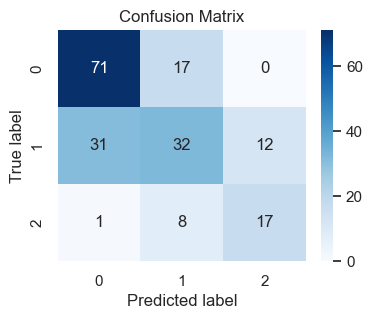

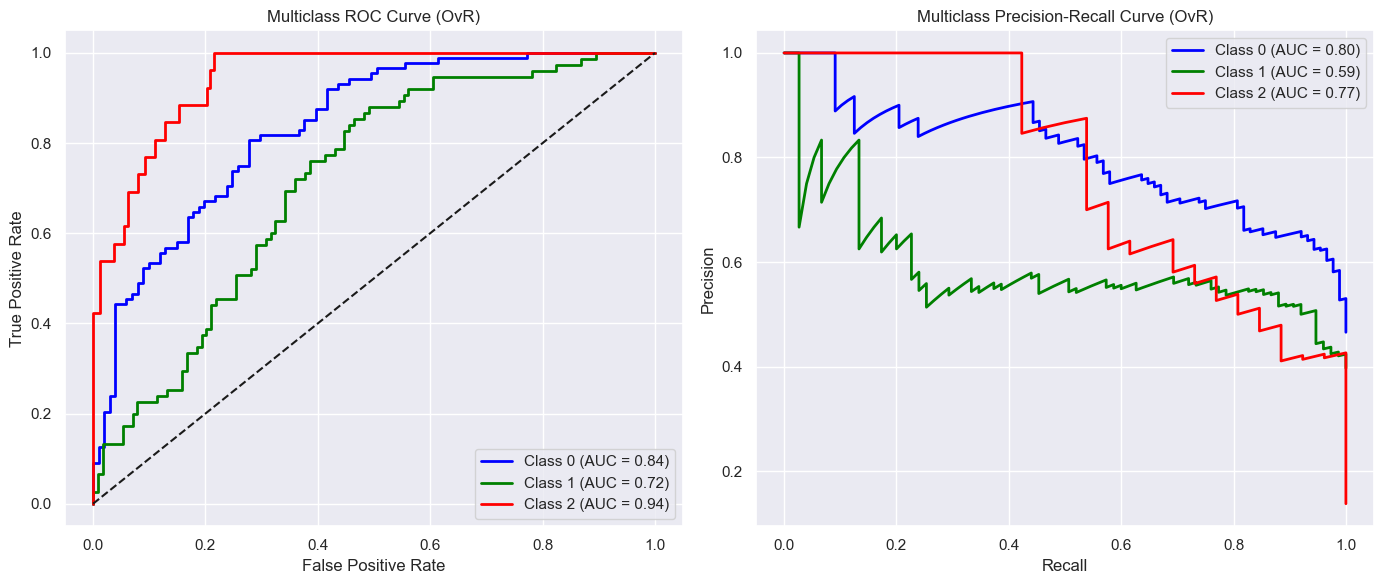


Binary classification results: all-star vs. others


=== Classification Report ===
               precision    recall  f1-score   support

           0       0.95      0.82      0.88       163
           1       0.40      0.73      0.51        26

    accuracy                           0.81       189
   macro avg       0.67      0.78      0.70       189
weighted avg       0.87      0.81      0.83       189


=== ROC AUC and PR AUC values ===
ROC AUC: 0.902784332232185
PR AUC: 0.6341325489448618


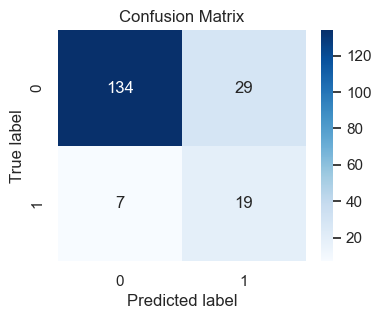

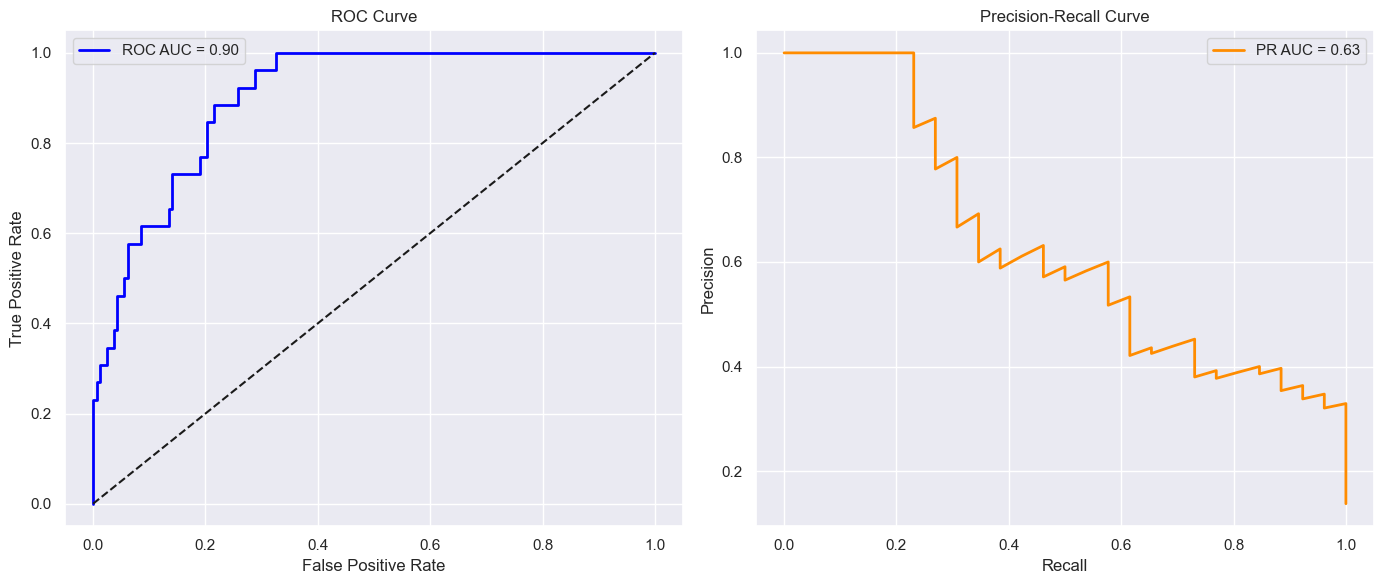


Binary classification results: starter vs. others


=== Classification Report ===
               precision    recall  f1-score   support

           0       0.77      0.66      0.71       114
           1       0.58      0.71      0.63        75

    accuracy                           0.68       189
   macro avg       0.67      0.68      0.67       189
weighted avg       0.69      0.68      0.68       189


=== ROC AUC and PR AUC values ===
ROC AUC: 0.7353216374269006
PR AUC: 0.5972045978842242


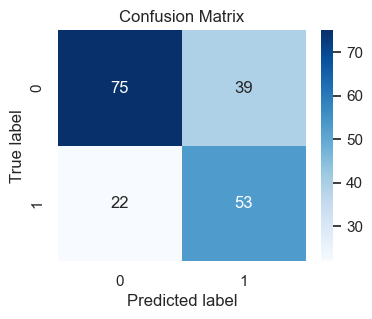

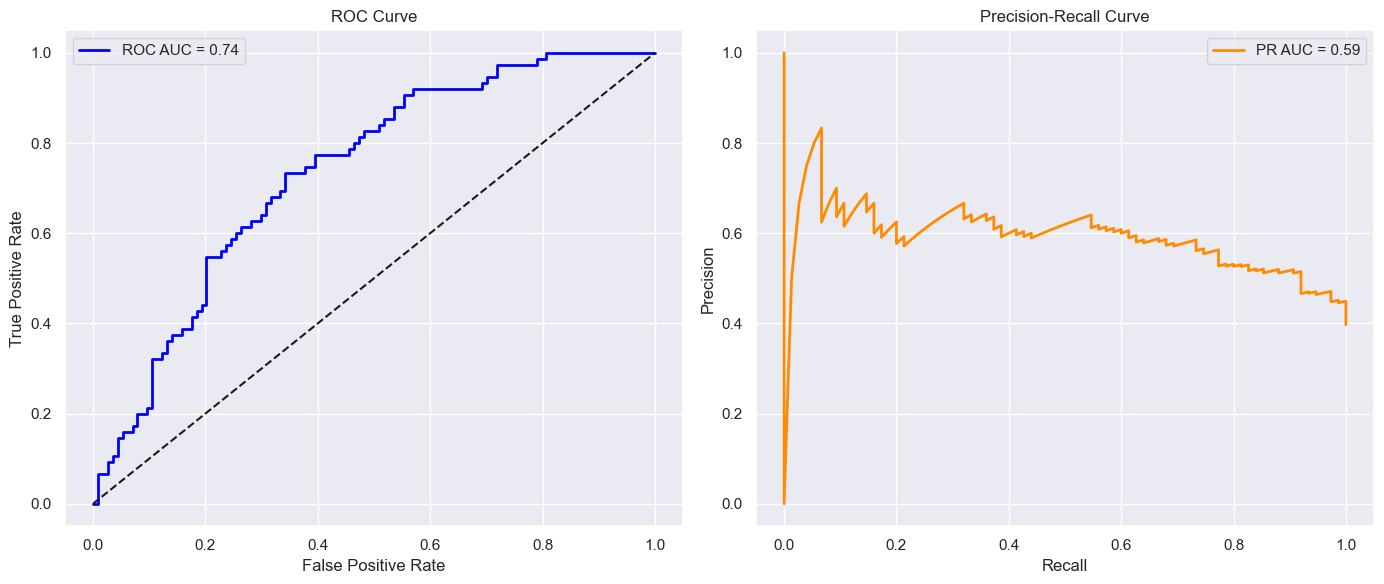


Binary classification results: bench vs. others


=== Classification Report ===
               precision    recall  f1-score   support

           0       0.81      0.81      0.81       101
           1       0.78      0.78      0.78        88

    accuracy                           0.80       189
   macro avg       0.80      0.80      0.80       189
weighted avg       0.80      0.80      0.80       189


=== ROC AUC and PR AUC values ===
ROC AUC: 0.875
PR AUC: 0.8530520509049546


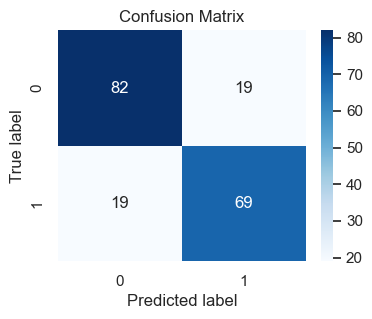

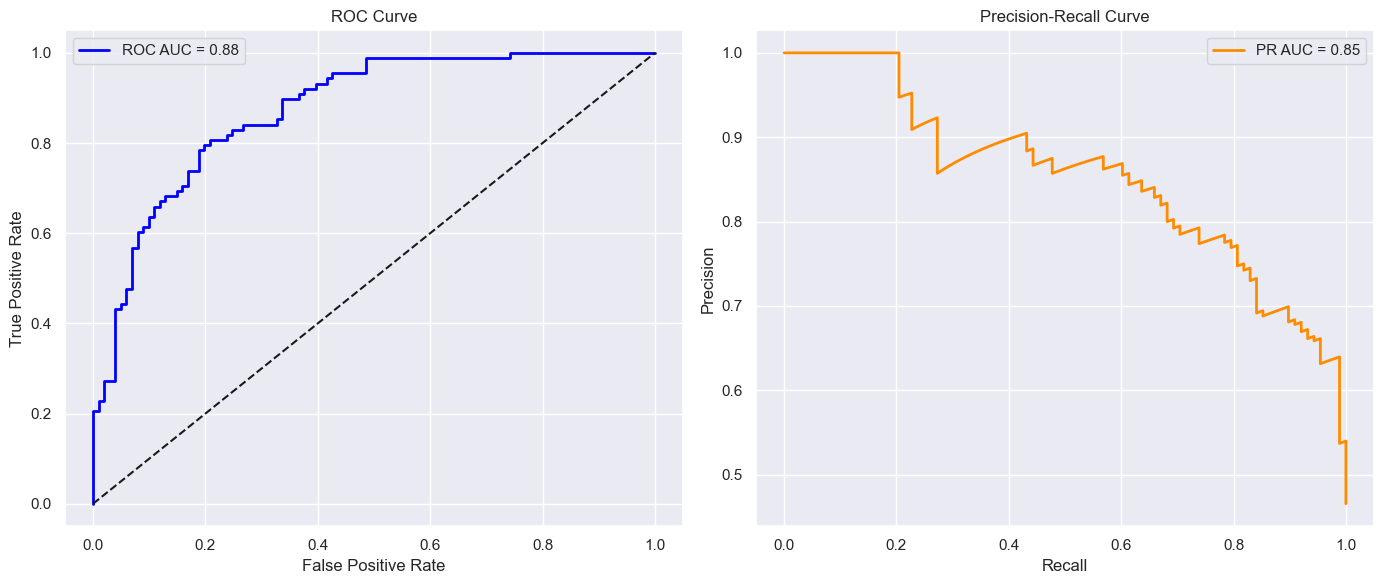

In [54]:
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = dict(zip(np.unique(y_train), class_weights))

keras_clf = KerasClassifier(
    model=create_model,
    verbose=0,
    input_dim=X_train.shape[1],
    num_classes=num_classes,
    optimizer='adam',
    activation='tanh',
    hidden_layers=[300],
    batch_size=32,
    epochs=100,
    random_state=42
)

keras_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', keras_clf)
])

keras_pipeline.fit(X_train, y_train, clf__class_weight=class_weights)

X_test_scaled = keras_pipeline.named_steps['scaler'].transform(X_test)
y_pred_proba = keras_pipeline.named_steps['clf'].predict_proba(X_test_scaled)
y_pred = np.argmax(y_pred_proba, axis=1)

calculate_evaluation_metrics(keras_pipeline.named_steps['clf'].model_, y_test, y_pred, y_pred_proba)

for class_num, class_label in zip([2, 1, 0], ["all-star", "starter", "bench"]):
    df_bin = final_dataset_3_seasons.copy()
    df_bin[f'{class_label}_class'] = df_bin['Player_class_num'].apply(lambda x: 1 if x == class_num else 0)

    X_bin = df_bin.drop(columns=['Player_class_num', f'{class_label}_class'])
    y_bin = df_bin[f'{class_label}_class']

    X_train_bin, X_test_bin, y_train_bin, y_test_bin = train_test_split(
        X_bin, y_bin, test_size=0.2, random_state=42, stratify=y_bin)
    
    class_weights = compute_class_weight(
        class_weight='balanced',
        classes=np.unique(y_train_bin),
        y=y_train_bin
    )
    class_weights = dict(zip(np.unique(y_train_bin), class_weights))

    keras_clf_bin = KerasClassifier(
        model=create_model,
        verbose=0,
        input_dim=X_train_bin.shape[1],
        num_classes=num_classes_bin,
        optimizer='adam',
        activation='tanh',
        hidden_layers=[300],
        batch_size=32,
        epochs=100,
        random_state=42
    )

    keras_pipeline_bin = Pipeline([
        ('scaler', StandardScaler()),
        ('clf', keras_clf_bin)
    ])

    keras_pipeline_bin.fit(X_train_bin, y_train_bin, clf__class_weight=class_weights)

    X_test_scaled_bin = keras_pipeline_bin.named_steps['scaler'].transform(X_test_bin)
    y_pred_proba_bin = keras_pipeline_bin.named_steps['clf'].predict_proba(X_test_scaled_bin)
    y_pred_bin = np.argmax(y_pred_proba_bin, axis=1)
    
    print(f"\nBinary classification results: {class_label} vs. others\n")
    calculate_evaluation_metrics(keras_pipeline_bin.named_steps['clf'].model_, y_test_bin, y_pred_bin, y_pred_proba_bin)


=== Classification Report ===
               precision    recall  f1-score   support

           0       0.82      0.51      0.63        88
           1       0.49      0.59      0.53        75
           2       0.45      0.77      0.57        26

    accuracy                           0.58       189
   macro avg       0.59      0.62      0.58       189
weighted avg       0.64      0.58      0.58       189


=== ROC AUC and PR AUC values ===
ROC AUC: 0.7899063120671704
PR AUC: 0.6347122046201195


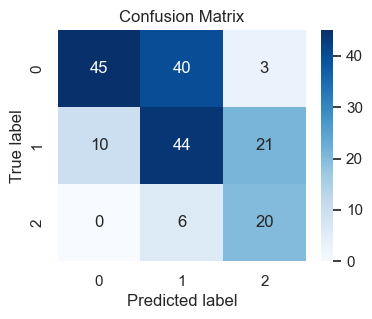

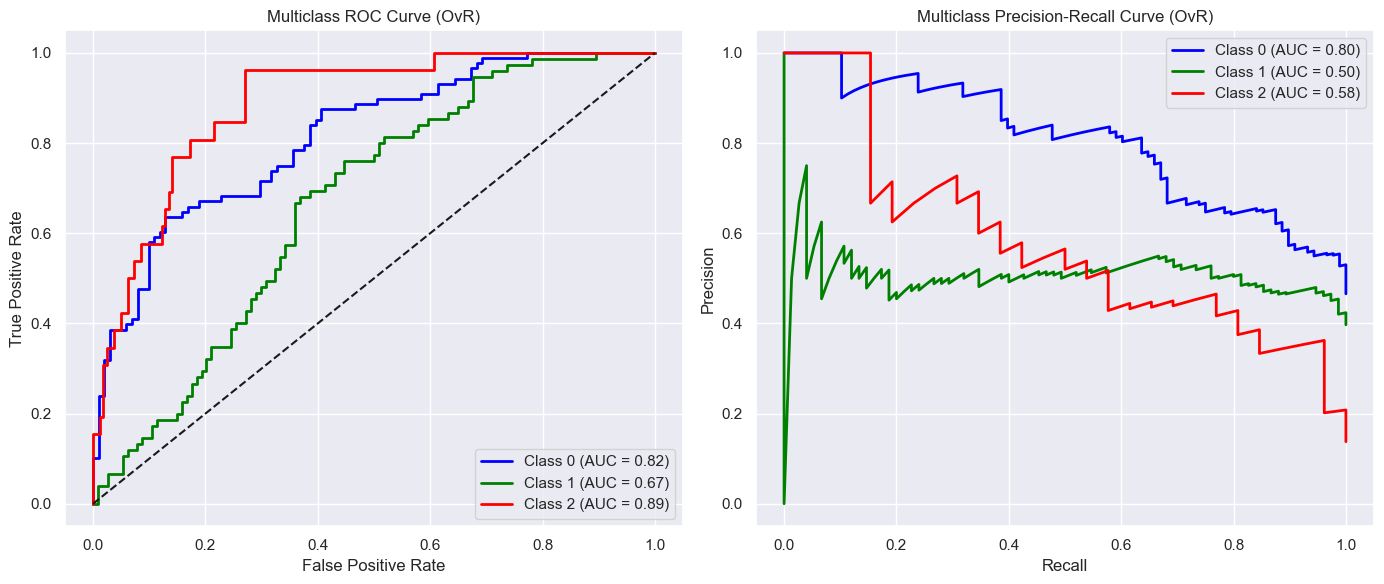


Binary classification results: all-star vs. others


=== Classification Report ===
               precision    recall  f1-score   support

           0       0.91      0.95      0.93       163
           1       0.58      0.42      0.49        26

    accuracy                           0.88       189
   macro avg       0.75      0.69      0.71       189
weighted avg       0.87      0.88      0.87       189


=== ROC AUC and PR AUC values ===
ROC AUC: 0.8975932043416706
PR AUC: 0.6138942854978019


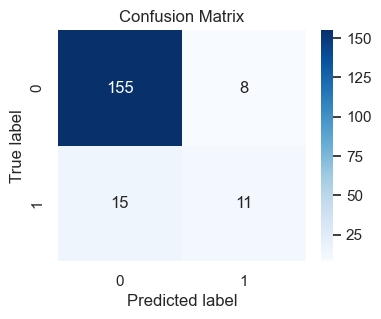

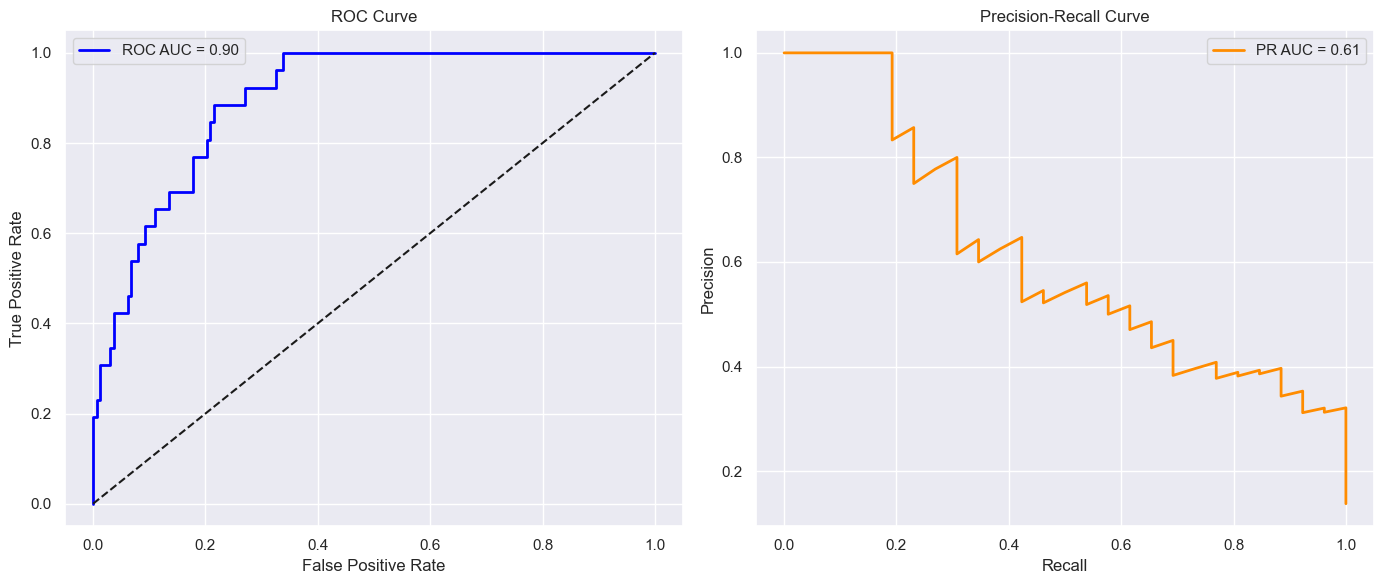


Binary classification results: starter vs. others


=== Classification Report ===
               precision    recall  f1-score   support

           0       0.74      0.74      0.74       114
           1       0.61      0.61      0.61        75

    accuracy                           0.69       189
   macro avg       0.67      0.68      0.67       189
weighted avg       0.69      0.69      0.69       189


=== ROC AUC and PR AUC values ===
ROC AUC: 0.7342690058479533
PR AUC: 0.5880057071453013


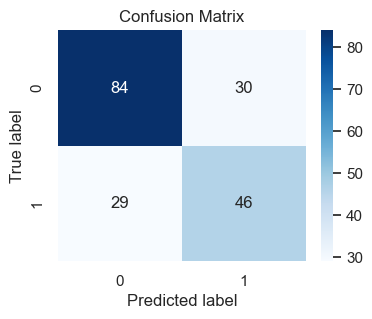

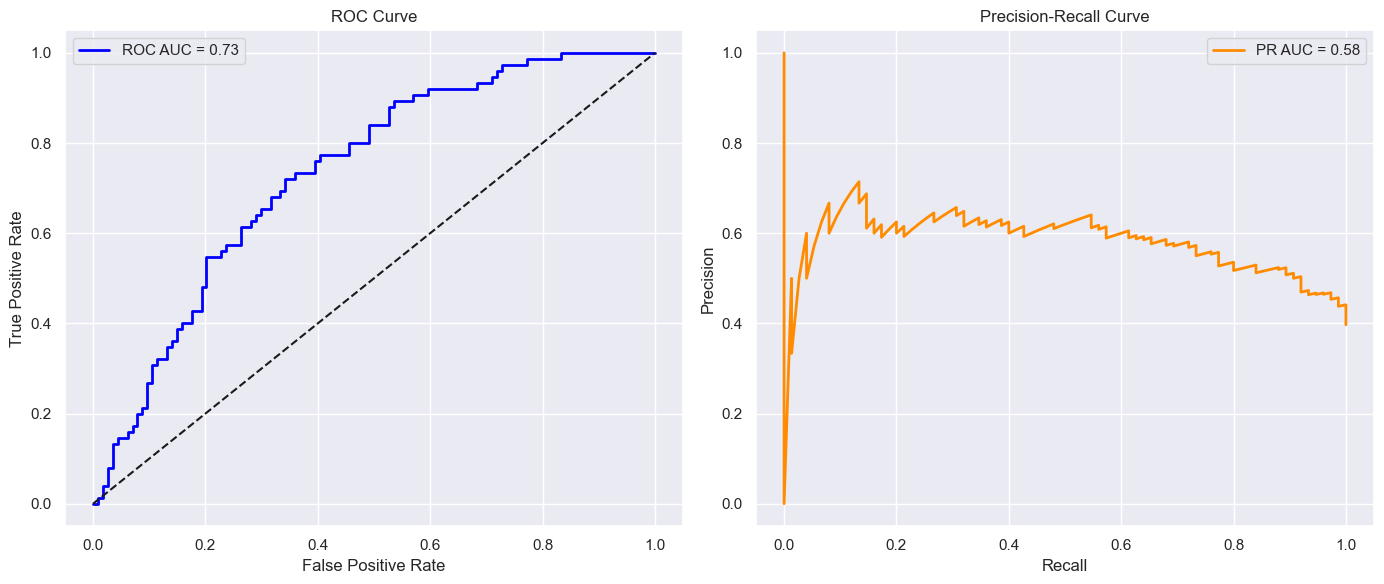


Binary classification results: bench vs. others


=== Classification Report ===
               precision    recall  f1-score   support

           0       0.78      0.81      0.80       101
           1       0.77      0.74      0.76        88

    accuracy                           0.78       189
   macro avg       0.78      0.78      0.78       189
weighted avg       0.78      0.78      0.78       189


=== ROC AUC and PR AUC values ===
ROC AUC: 0.8748874887488749
PR AUC: 0.8534081466931248


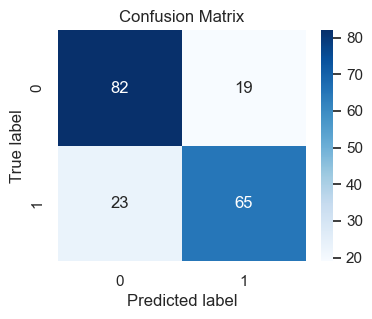

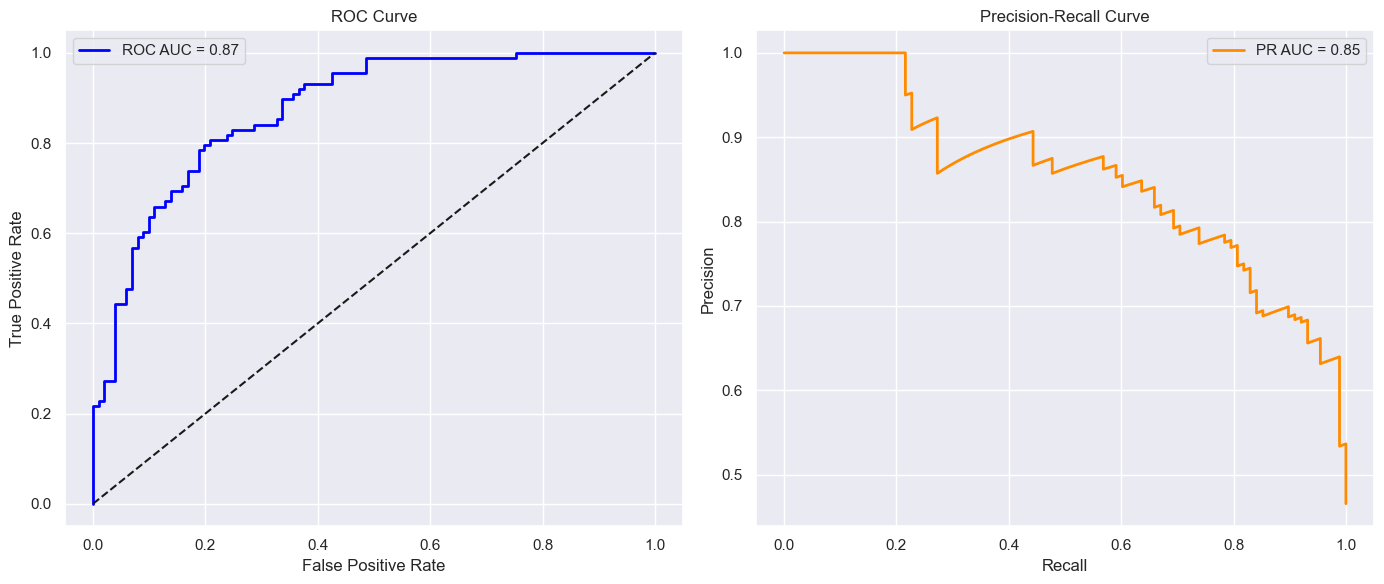

In [55]:
keras_clf = KerasClassifier(
    model=create_model,
    verbose=0,
    model__input_dim=X_train.shape[1],
    model__num_classes=num_classes,
    model__optimizer='adam',
    model__activation='tanh',
    model__hidden_layers=[300],
    batch_size=32,
    epochs=100,
    random_state=42
)

keras_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', keras_clf)
])
ovr = OneVsRestClassifier(keras_pipeline.named_steps['clf'])
ovr.fit(X_train, y_train)

y_pred_proba = ovr.predict_proba(X_test)

custom_preds = []
for probs in y_pred_proba:
    if probs[2] >= 0.25:        
        custom_preds.append(2)
    elif probs[1] >= 0.35:      
        custom_preds.append(1)
    else:
        custom_preds.append(0) 
        
y_pred_proba = y_pred_proba / y_pred_proba.sum(axis=1, keepdims=True)

calculate_evaluation_metrics(ovr, y_test, custom_preds, y_pred_proba)

for class_num, class_label in zip([2, 1, 0], ["all-star", "starter", "bench"]):
    df_bin = final_dataset_3_seasons.copy()
    df_bin[f'{class_label}_class'] = df_bin['Player_class_num'].apply(lambda x: 1 if x == class_num else 0)

    X_bin = df_bin.drop(columns=['Player_class_num', f'{class_label}_class'])
    y_bin = df_bin[f'{class_label}_class']

    X_train_bin, X_test_bin, y_train_bin, y_test_bin = train_test_split(
        X_bin, y_bin, test_size=0.2, random_state=42, stratify=y_bin)
    
    num_classes_bin = len(np.unique(y_train_bin))

    keras_clf_bin = KerasClassifier(
        model=create_model,
        verbose=0,
        input_dim=X_train_bin.shape[1],
        num_classes=num_classes_bin,
        optimizer='adam',
        activation='tanh',
        hidden_layers=[300],
        batch_size=32,
        epochs=100,
        random_state=42
    )

    keras_pipeline_bin = Pipeline([
        ('scaler', StandardScaler()),
        ('clf', keras_clf_bin)
    ])

    keras_pipeline_bin.fit(X_train_bin, y_train_bin)

    X_test_scaled_bin = keras_pipeline_bin.named_steps['scaler'].transform(X_test_bin)
    y_pred_proba_bin = keras_pipeline_bin.named_steps['clf'].predict_proba(X_test_scaled_bin)
    y_pred_bin = np.argmax(y_pred_proba_bin, axis=1)
    
    print(f"\nBinary classification results: {class_label} vs. others\n")
    calculate_evaluation_metrics(keras_pipeline_bin.named_steps['clf'].model_, y_test_bin, y_pred_bin, y_pred_proba_bin)

Number of elements in each class:
Player_class_num
0    351
1    300
2    102
Name: count, dtype: int64

Number of elements in each class after sampling:
Player_class_num
1    351
0    351
2    351
Name: count, dtype: int64

=== Classification Report ===
               precision    recall  f1-score   support

           0       0.68      0.76      0.72        88
           1       0.54      0.48      0.51        75
           2       0.57      0.50      0.53        26

    accuracy                           0.61       189
   macro avg       0.59      0.58      0.58       189
weighted avg       0.61      0.61      0.61       189


=== ROC AUC and PR AUC values ===
ROC AUC: 0.8197644057062785
PR AUC: 0.6831236315048712


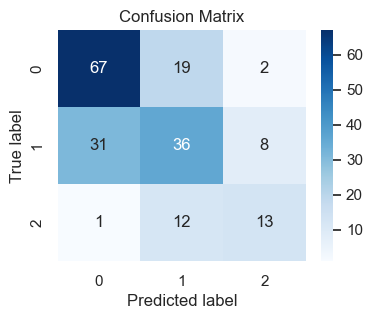

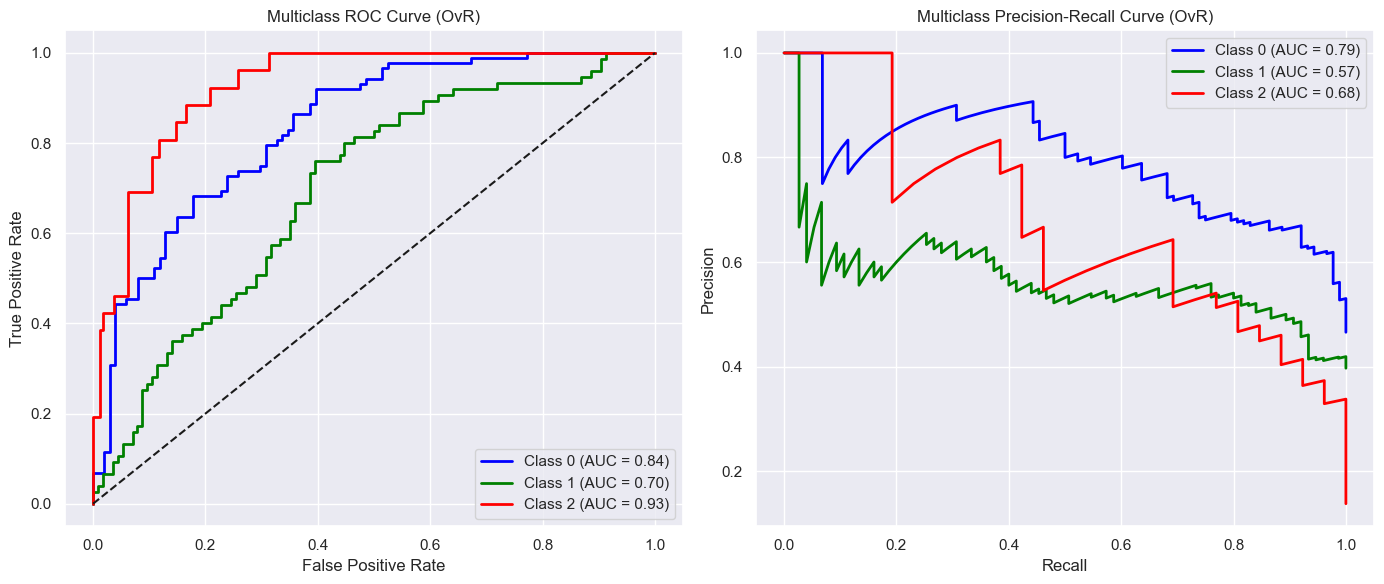

Number of elements in each class:
Player_class_num
0    351
1    300
2    102
Name: count, dtype: int64

Number of elements in each class after sampling:
all-star_class
0    651
1    651
Name: count, dtype: int64

Binary classification results: all-star vs. others


=== Classification Report ===
               precision    recall  f1-score   support

           0       0.93      0.85      0.89       163
           1       0.40      0.62      0.48        26

    accuracy                           0.82       189
   macro avg       0.67      0.73      0.69       189
weighted avg       0.86      0.82      0.84       189


=== ROC AUC and PR AUC values ===
ROC AUC: 0.8827277017461066
PR AUC: 0.5464739185313824


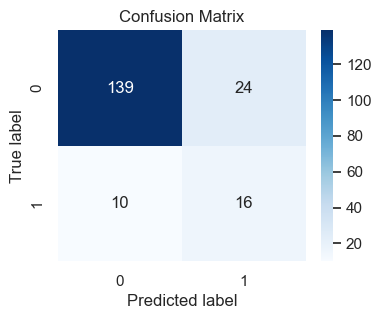

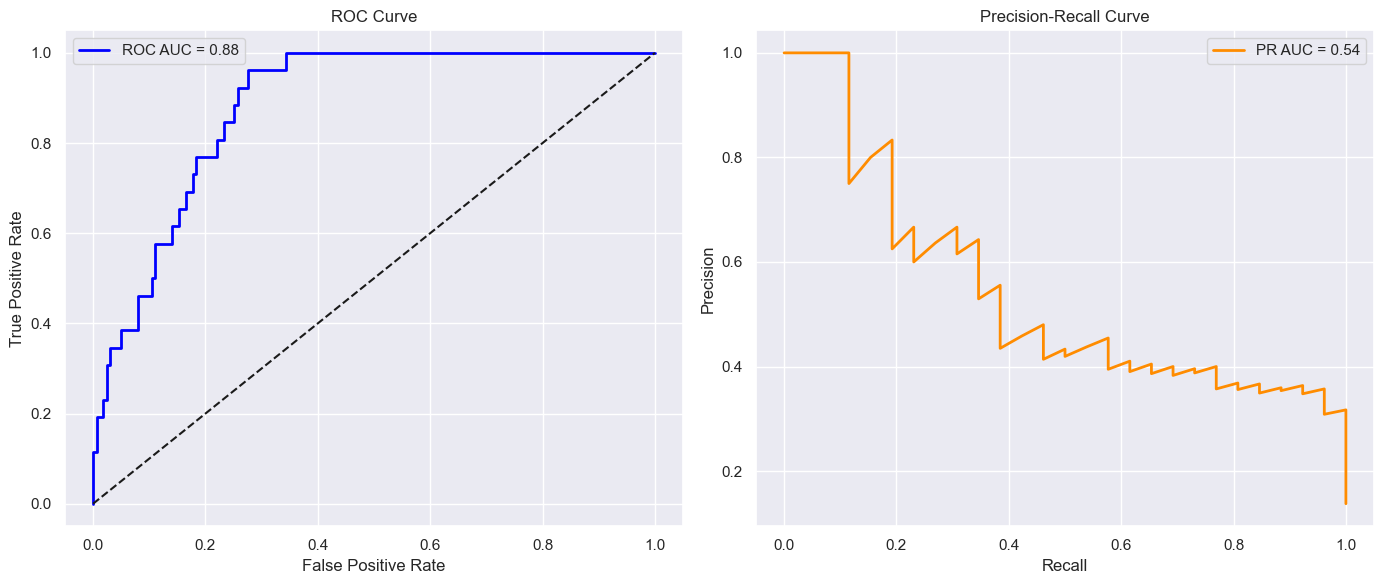

Number of elements in each class:
Player_class_num
0    351
1    300
2    102
Name: count, dtype: int64

Number of elements in each class after sampling:
starter_class
1    453
0    453
Name: count, dtype: int64

Binary classification results: starter vs. others


=== Classification Report ===
               precision    recall  f1-score   support

           0       0.77      0.66      0.71       114
           1       0.58      0.71      0.63        75

    accuracy                           0.68       189
   macro avg       0.67      0.68      0.67       189
weighted avg       0.69      0.68      0.68       189


=== ROC AUC and PR AUC values ===
ROC AUC: 0.736140350877193
PR AUC: 0.5851652916690651


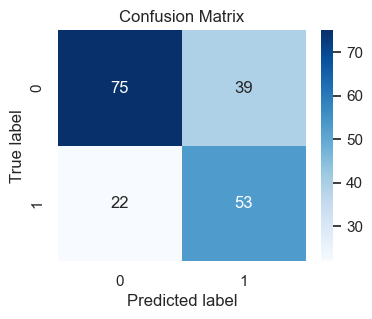

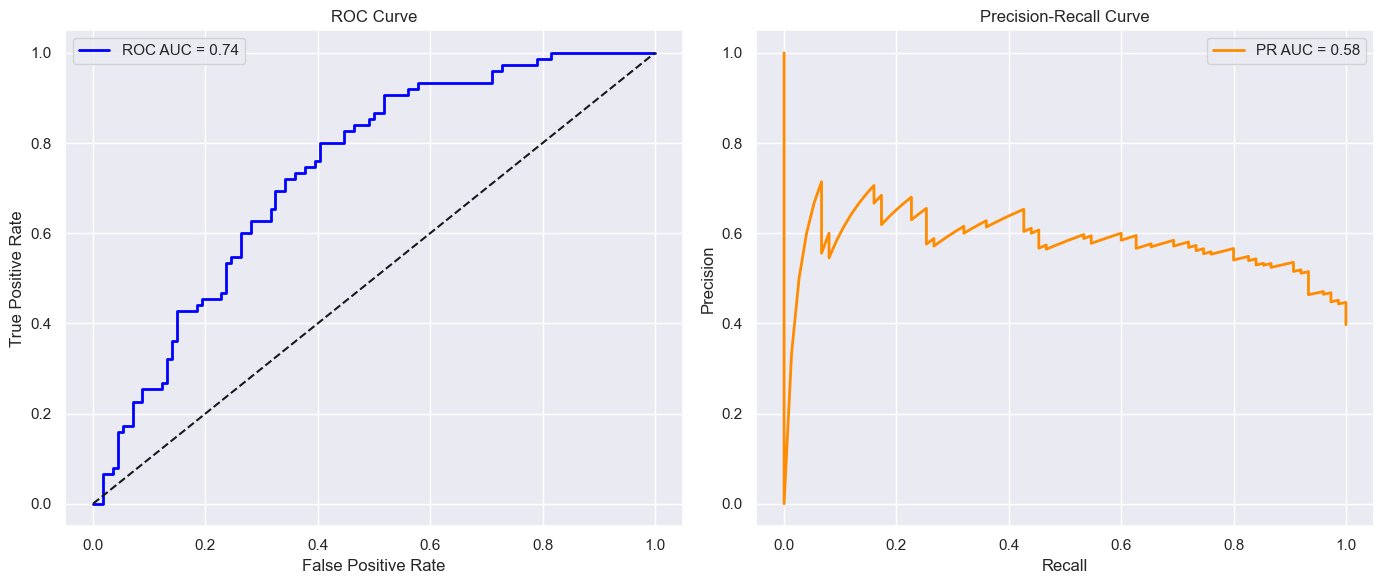

Number of elements in each class:
Player_class_num
0    351
1    300
2    102
Name: count, dtype: int64

Number of elements in each class after sampling:
bench_class
1    402
0    402
Name: count, dtype: int64

Binary classification results: bench vs. others


=== Classification Report ===
               precision    recall  f1-score   support

           0       0.80      0.78      0.79       101
           1       0.76      0.77      0.76        88

    accuracy                           0.78       189
   macro avg       0.78      0.78      0.78       189
weighted avg       0.78      0.78      0.78       189


=== ROC AUC and PR AUC values ===
ROC AUC: 0.8729747974797479
PR AUC: 0.8533065271742857


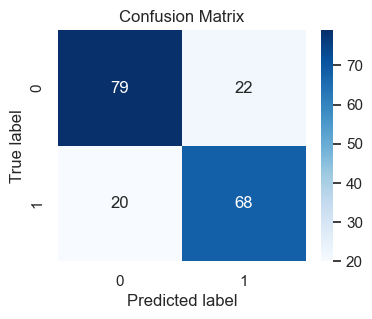

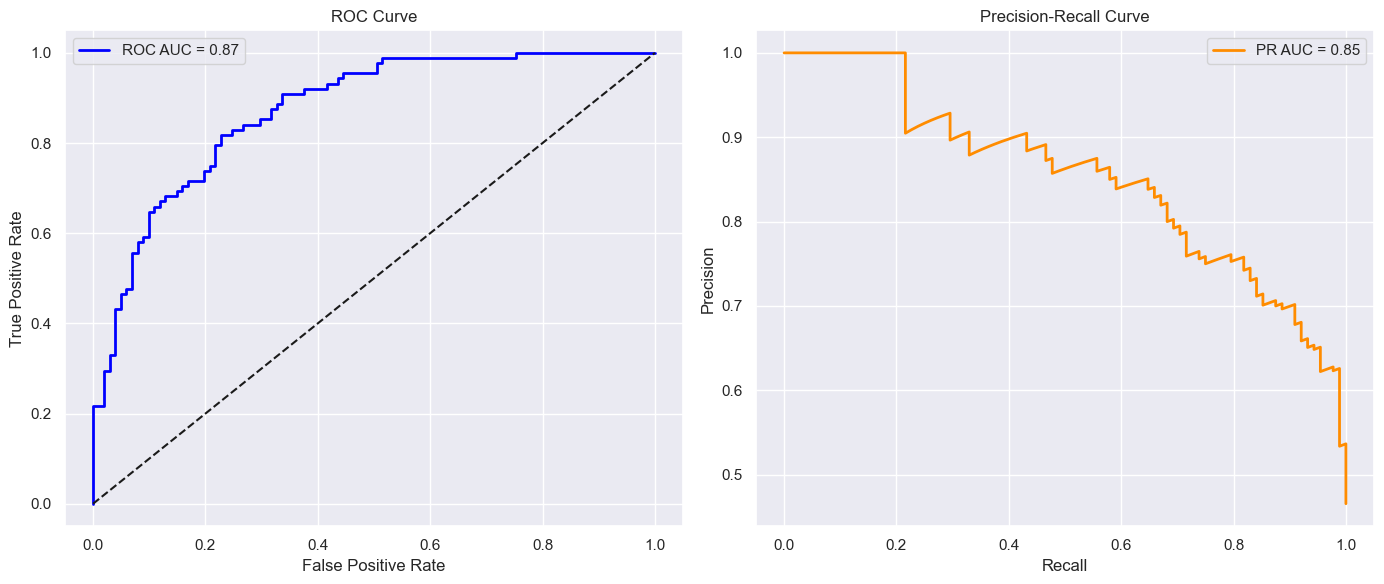

In [56]:
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X_train, y_train)

print('Number of elements in each class:')
print(y_train.value_counts())
print('\nNumber of elements in each class after sampling:')
print(pd.Series(y_res).value_counts())

num_classes = len(np.unique(y_res))

keras_clf = KerasClassifier(
    model=create_model,
    verbose=0,
    model__input_dim=X_res.shape[1],
    model__num_classes=num_classes,
    model__optimizer='adam',
    model__activation='tanh',
    model__hidden_layers=[300],
    batch_size=32,
    epochs=100,
    random_state=42
)

keras_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', keras_clf)
])

keras_pipeline.fit(X_res, y_res)

X_test_scaled = keras_pipeline.named_steps['scaler'].transform(X_test)
y_pred_proba = keras_pipeline.named_steps['clf'].predict_proba(X_test_scaled)
y_pred = np.argmax(y_pred_proba, axis=1)

calculate_evaluation_metrics(keras_pipeline.named_steps['clf'].model_, y_test, y_pred, y_pred_proba)

for class_num, class_label in zip([2, 1, 0], ["all-star", "starter", "bench"]):
    df_bin = final_dataset_3_seasons.copy()
    df_bin[f'{class_label}_class'] = df_bin['Player_class_num'].apply(lambda x: 1 if x == class_num else 0)

    X_bin = df_bin.drop(columns=['Player_class_num', f'{class_label}_class'])
    y_bin = df_bin[f'{class_label}_class']

    X_train_bin, X_test_bin, y_train_bin, y_test_bin = train_test_split(
        X_bin, y_bin, test_size=0.2, random_state=42, stratify=y_bin)
    
    smote = SMOTE(random_state=42)
    X_res_bin, y_res_bin = smote.fit_resample(X_train_bin, y_train_bin)

    print('Number of elements in each class:')
    print(y_train.value_counts())
    print('\nNumber of elements in each class after sampling:')
    print(pd.Series(y_res_bin).value_counts())
    
    num_classes_bin = len(np.unique(y_res_bin))

    keras_clf_bin = KerasClassifier(
        model=create_model,
        verbose=0,
        input_dim=X_train_bin.shape[1],
        num_classes=num_classes_bin,
        optimizer='adam',
        activation='tanh',
        hidden_layers=[300],
        batch_size=32,
        epochs=100,
        random_state=42
    )

    keras_pipeline_bin = Pipeline([
        ('scaler', StandardScaler()),
        ('clf', keras_clf_bin)
    ])

    keras_pipeline_bin.fit(X_res_bin, y_res_bin)

    X_test_scaled_bin = keras_pipeline_bin.named_steps['scaler'].transform(X_test_bin)
    y_pred_proba_bin = keras_pipeline_bin.named_steps['clf'].predict_proba(X_test_scaled_bin)
    y_pred_bin = np.argmax(y_pred_proba_bin, axis=1)
    
    print(f"\nBinary classification results: {class_label} vs. others\n")
    calculate_evaluation_metrics(keras_pipeline_bin.named_steps['clf'].model_, y_test_bin, y_pred_bin, y_pred_proba_bin)

<h3>Classification results, input: statistics from the <b>rookie</b> season</h3>

In [57]:
df_1 = pd.read_csv('data/final_dataset_1_seasons.csv', low_memory=False)

class_mapping = {'bench': 0, 'starter': 1, 'all-star': 2}
df_1['Player_class_num'] = df_1['Player_class'].map(class_mapping)

final_dataset_1_seasons = df_1[get_selected_features(1)]

X = final_dataset_1_seasons.drop(columns=['Player_class_num'])
y = final_dataset_1_seasons['Player_class_num']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


=== Classification Report ===
               precision    recall  f1-score   support

           0       0.70      0.73      0.71        88
           1       0.53      0.45      0.49        75
           2       0.39      0.50      0.44        26

    accuracy                           0.59       189
   macro avg       0.54      0.56      0.55       189
weighted avg       0.59      0.59      0.59       189


=== ROC AUC and PR AUC values ===
ROC AUC: 0.7589518473137561
PR AUC: 0.6006126598702846


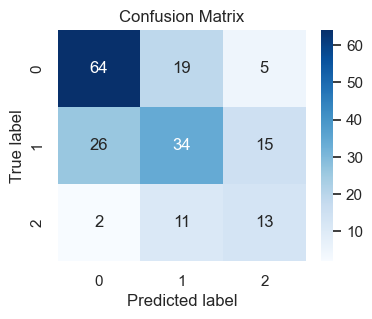

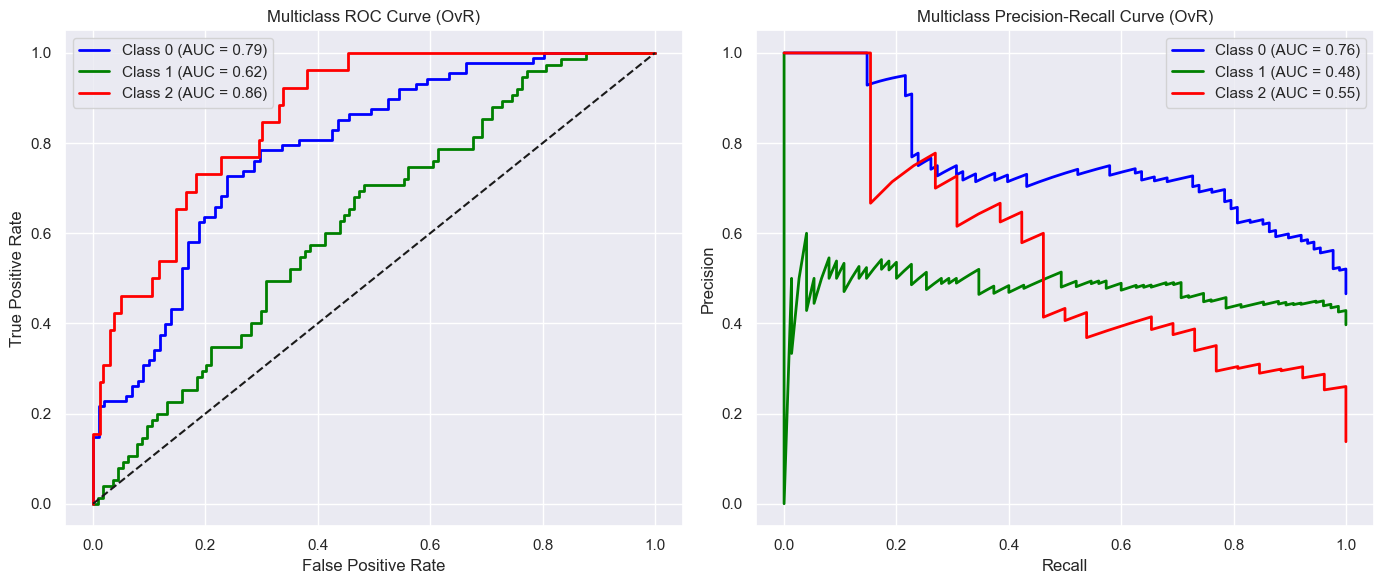


Binary classification results: all-star vs. others


=== Classification Report ===
               precision    recall  f1-score   support

           0       0.95      0.78      0.86       163
           1       0.35      0.73      0.47        26

    accuracy                           0.77       189
   macro avg       0.65      0.75      0.66       189
weighted avg       0.86      0.77      0.80       189


=== ROC AUC and PR AUC values ===
ROC AUC: 0.8282208588957055
PR AUC: 0.48711773401425246


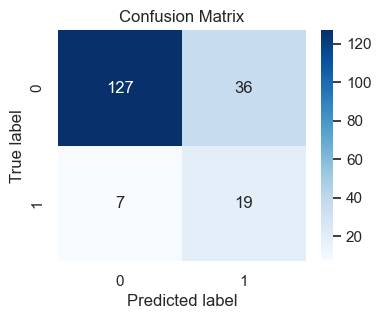

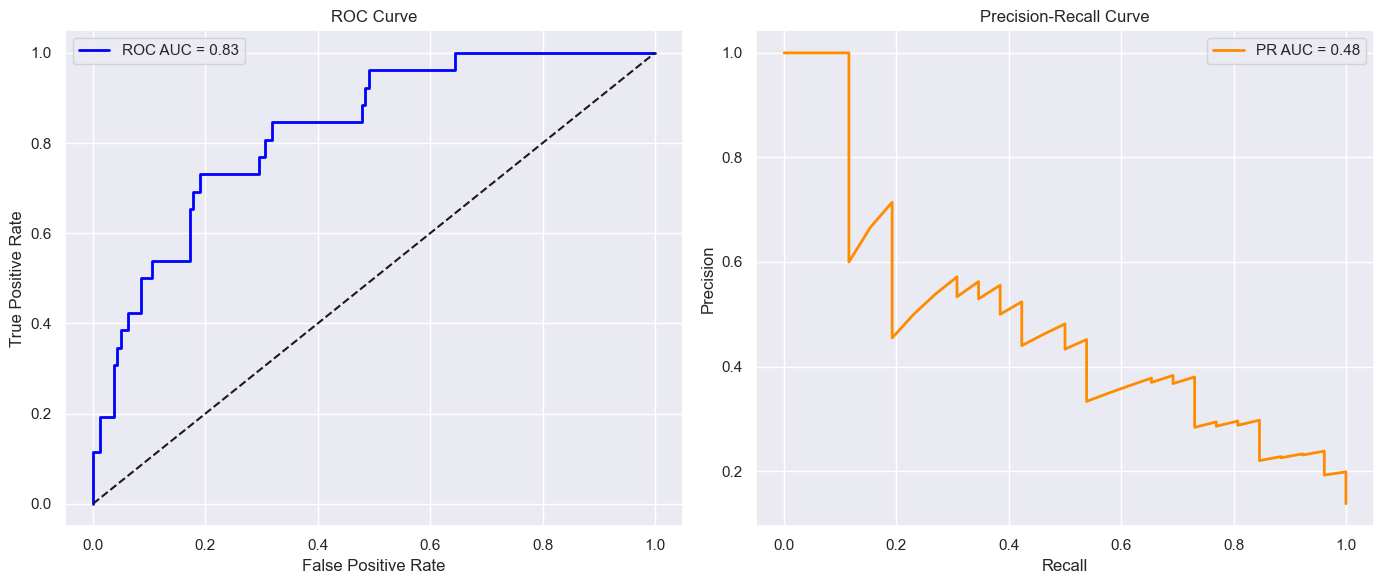


Binary classification results: starter vs. others


=== Classification Report ===
               precision    recall  f1-score   support

           0       0.71      0.63      0.67       114
           1       0.52      0.61      0.56        75

    accuracy                           0.62       189
   macro avg       0.62      0.62      0.62       189
weighted avg       0.64      0.62      0.63       189


=== ROC AUC and PR AUC values ===
ROC AUC: 0.6784795321637427
PR AUC: 0.5488568225964192


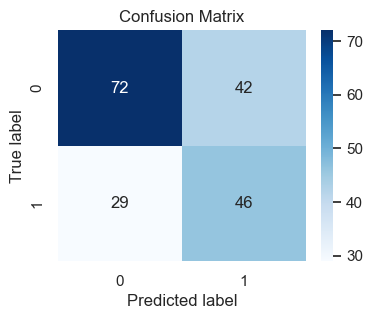

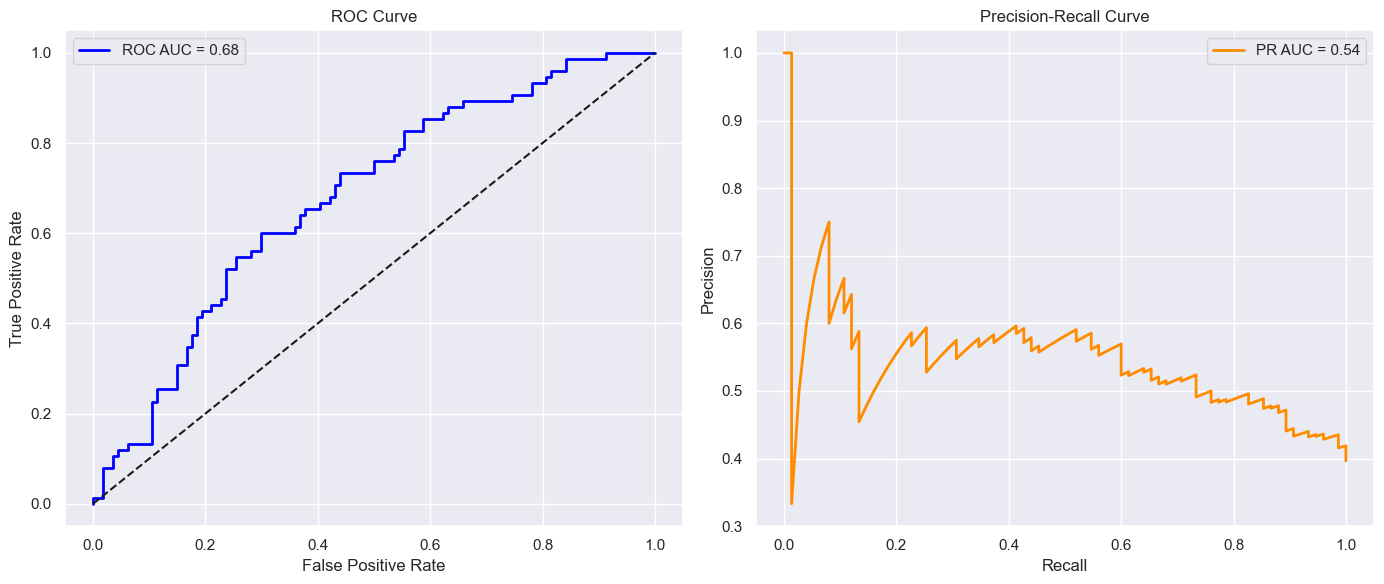


Binary classification results: bench vs. others


=== Classification Report ===
               precision    recall  f1-score   support

           0       0.79      0.68      0.73       101
           1       0.69      0.80      0.74        88

    accuracy                           0.74       189
   macro avg       0.74      0.74      0.74       189
weighted avg       0.74      0.74      0.74       189


=== ROC AUC and PR AUC values ===
ROC AUC: 0.836071107110711
PR AUC: 0.8074097834239022


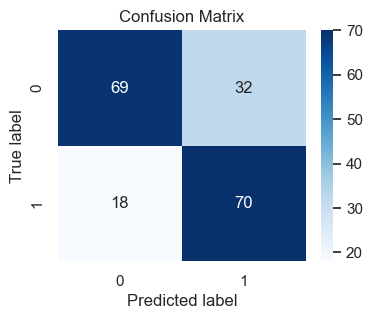

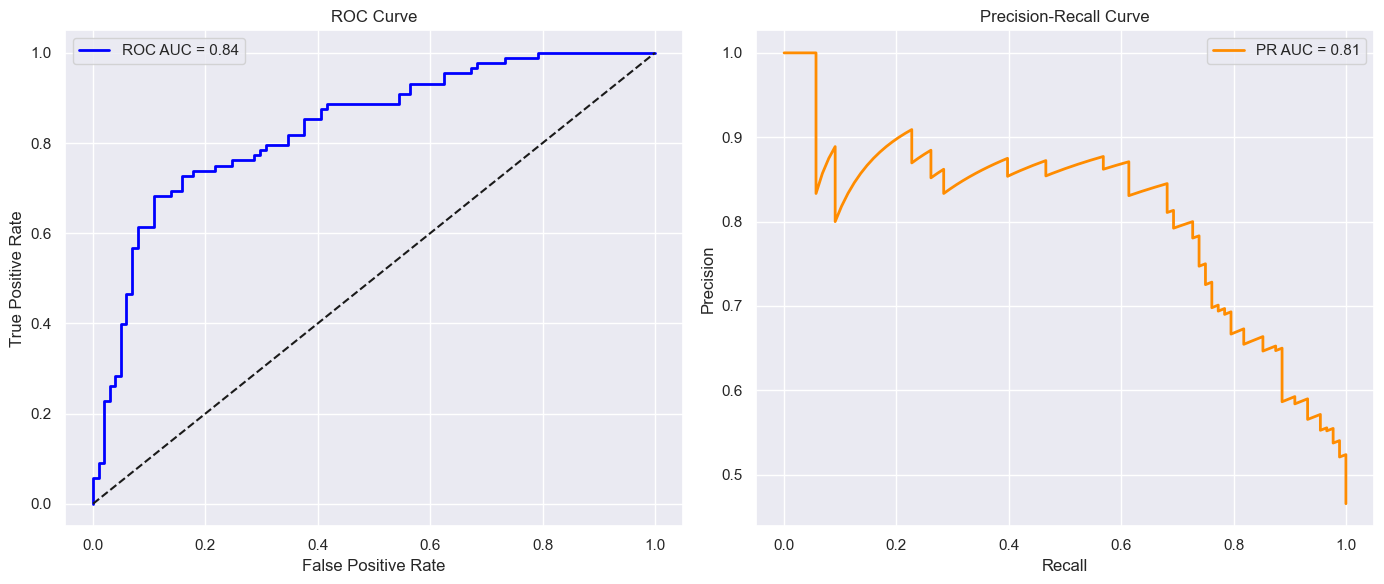

In [58]:
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = dict(zip(np.unique(y_train), class_weights))

keras_clf = KerasClassifier(
    model=create_model,
    verbose=0,
    input_dim=X_train.shape[1],
    num_classes=num_classes,
    optimizer='adam',
    activation='tanh',
    hidden_layers=[300],
    batch_size=32,
    epochs=100,
    random_state=42
)

keras_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', keras_clf)
])

keras_pipeline.fit(X_train, y_train, clf__class_weight=class_weights)

X_test_scaled = keras_pipeline.named_steps['scaler'].transform(X_test)
y_pred_proba = keras_pipeline.named_steps['clf'].predict_proba(X_test_scaled)
y_pred = np.argmax(y_pred_proba, axis=1)

calculate_evaluation_metrics(keras_pipeline.named_steps['clf'].model_, y_test, y_pred, y_pred_proba)

for class_num, class_label in zip([2, 1, 0], ["all-star", "starter", "bench"]):
    df_bin = final_dataset_1_seasons.copy()
    df_bin[f'{class_label}_class'] = df_bin['Player_class_num'].apply(lambda x: 1 if x == class_num else 0)

    X_bin = df_bin.drop(columns=['Player_class_num', f'{class_label}_class'])
    y_bin = df_bin[f'{class_label}_class']

    X_train_bin, X_test_bin, y_train_bin, y_test_bin = train_test_split(
        X_bin, y_bin, test_size=0.2, random_state=42, stratify=y_bin)
    
    class_weights = compute_class_weight(
        class_weight='balanced',
        classes=np.unique(y_train_bin),
        y=y_train_bin
    )
    class_weights = dict(zip(np.unique(y_train_bin), class_weights))

    keras_clf_bin = KerasClassifier(
        model=create_model,
        verbose=0,
        input_dim=X_train_bin.shape[1],
        num_classes=num_classes_bin,
        optimizer='adam',
        activation='tanh',
        hidden_layers=[300],
        batch_size=32,
        epochs=100,
        random_state=42
    )

    keras_pipeline_bin = Pipeline([
        ('scaler', StandardScaler()),
        ('clf', keras_clf_bin)
    ])

    keras_pipeline_bin.fit(X_train_bin, y_train_bin, clf__class_weight=class_weights)

    X_test_scaled_bin = keras_pipeline_bin.named_steps['scaler'].transform(X_test_bin)
    y_pred_proba_bin = keras_pipeline_bin.named_steps['clf'].predict_proba(X_test_scaled_bin)
    y_pred_bin = np.argmax(y_pred_proba_bin, axis=1)
    
    print(f"\nBinary classification results: {class_label} vs. others\n")
    calculate_evaluation_metrics(keras_pipeline_bin.named_steps['clf'].model_, y_test_bin, y_pred_bin, y_pred_proba_bin)


=== Classification Report ===
               precision    recall  f1-score   support

           0       0.64      0.51      0.57        88
           1       0.42      0.43      0.42        75
           2       0.33      0.54      0.41        26

    accuracy                           0.48       189
   macro avg       0.46      0.49      0.47       189
weighted avg       0.51      0.48      0.49       189


=== ROC AUC and PR AUC values ===
ROC AUC: 0.6730779935829537
PR AUC: 0.4776532727728358


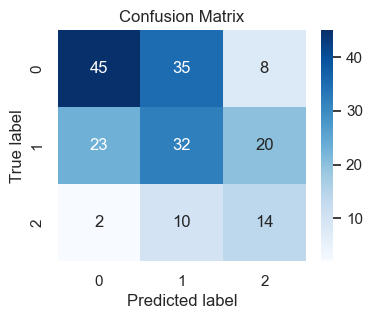

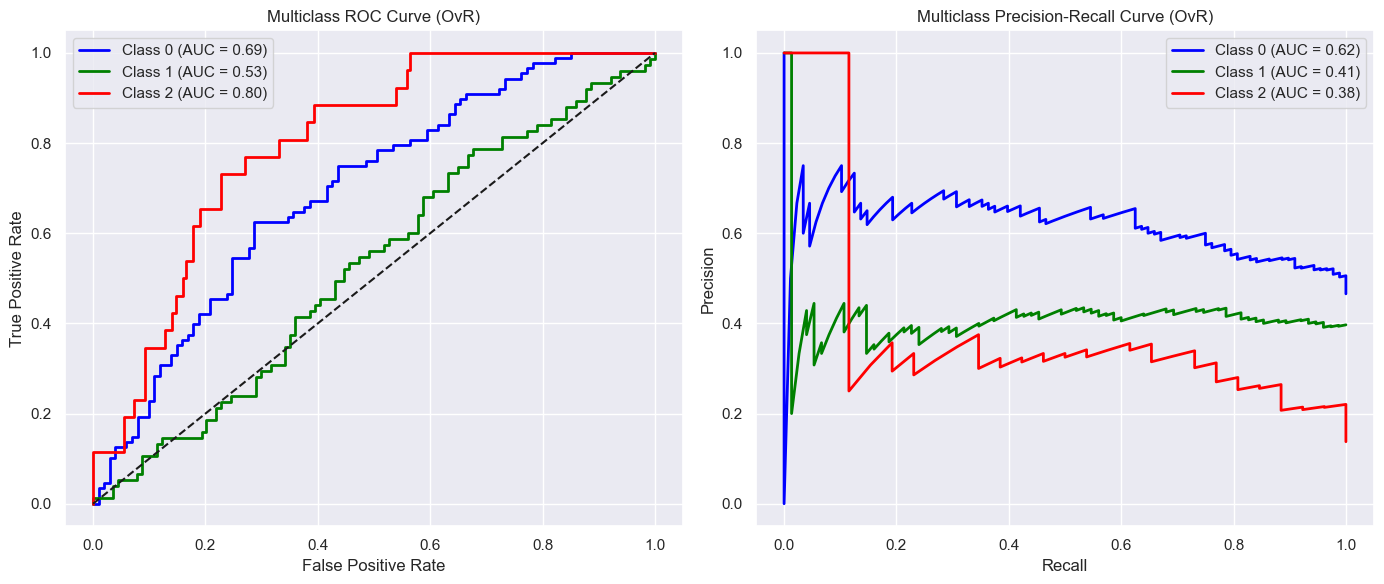


Binary classification results: all-star vs. others


=== Classification Report ===
               precision    recall  f1-score   support

           0       0.90      0.94      0.92       163
           1       0.50      0.35      0.41        26

    accuracy                           0.86       189
   macro avg       0.70      0.65      0.67       189
weighted avg       0.85      0.86      0.85       189


=== ROC AUC and PR AUC values ===
ROC AUC: 0.8227937706465314
PR AUC: 0.45577269541086063


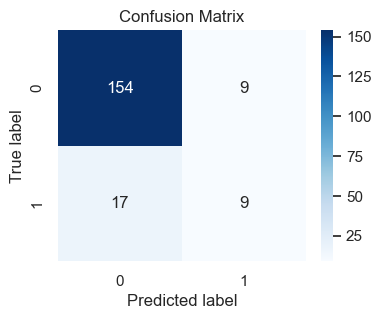

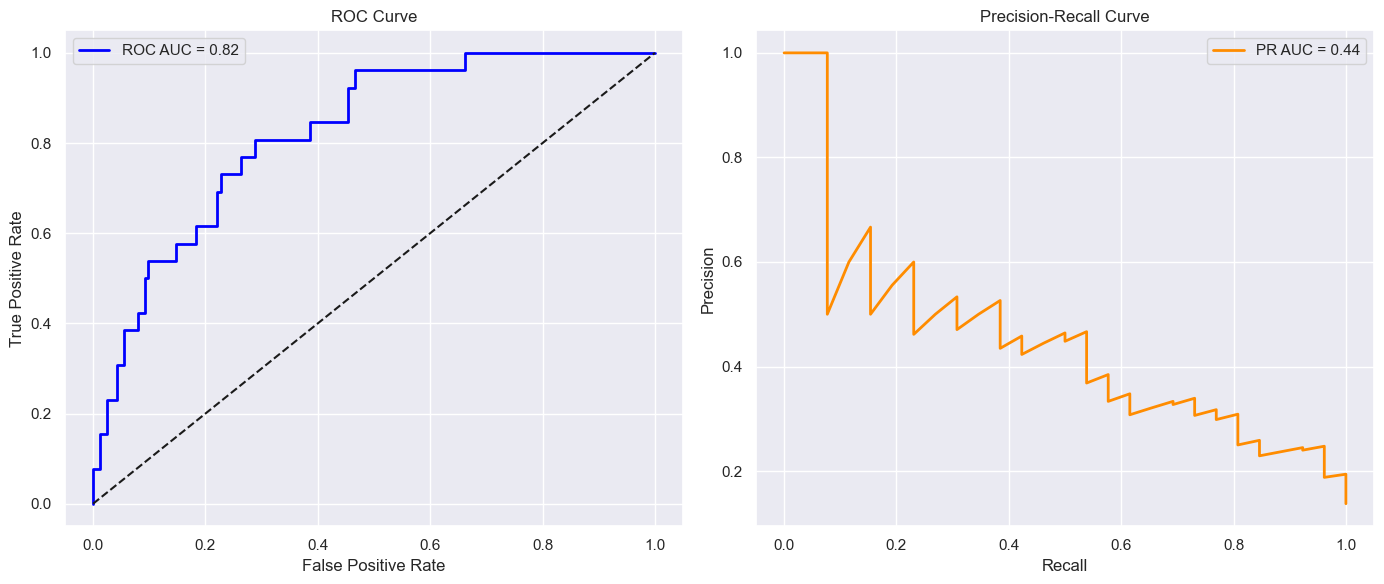


Binary classification results: starter vs. others


=== Classification Report ===
               precision    recall  f1-score   support

           0       0.68      0.76      0.72       114
           1       0.56      0.45      0.50        75

    accuracy                           0.64       189
   macro avg       0.62      0.61      0.61       189
weighted avg       0.63      0.64      0.63       189


=== ROC AUC and PR AUC values ===
ROC AUC: 0.6754385964912282
PR AUC: 0.5432558844734434


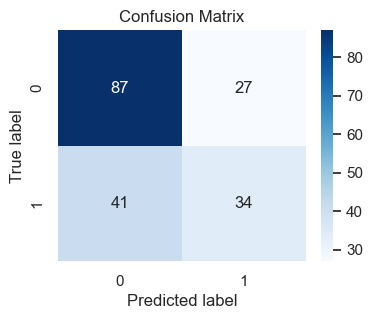

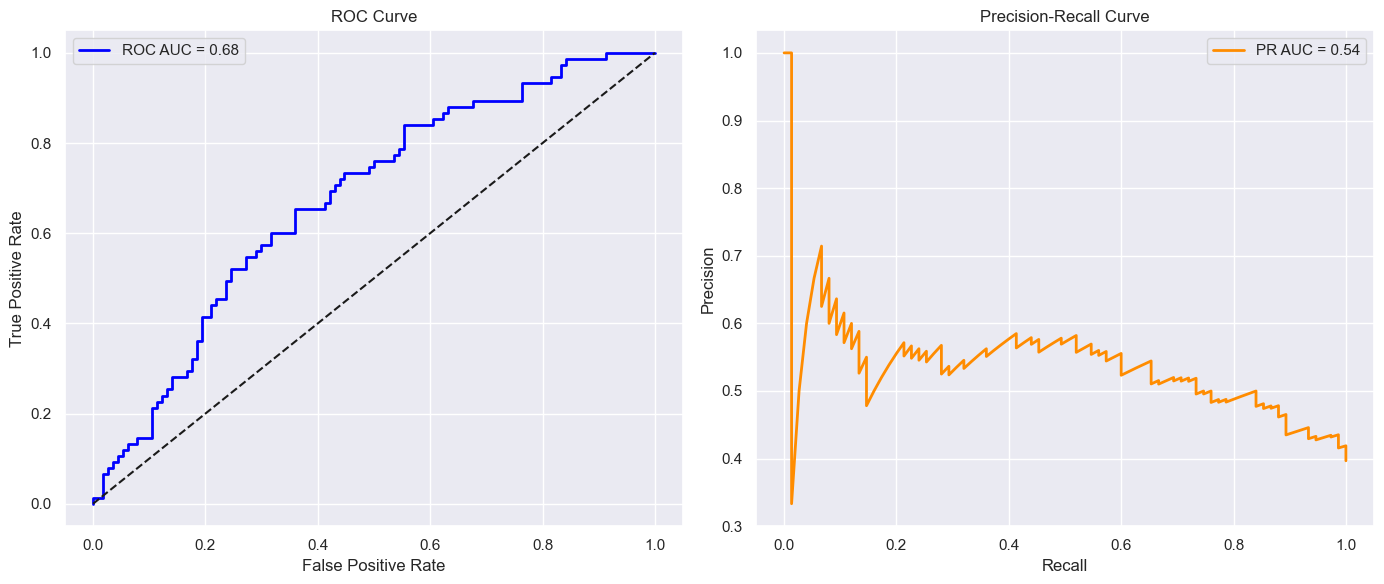


Binary classification results: bench vs. others


=== Classification Report ===
               precision    recall  f1-score   support

           0       0.78      0.72      0.75       101
           1       0.71      0.76      0.73        88

    accuracy                           0.74       189
   macro avg       0.74      0.74      0.74       189
weighted avg       0.74      0.74      0.74       189


=== ROC AUC and PR AUC values ===
ROC AUC: 0.8353960396039604
PR AUC: 0.8068567759482543


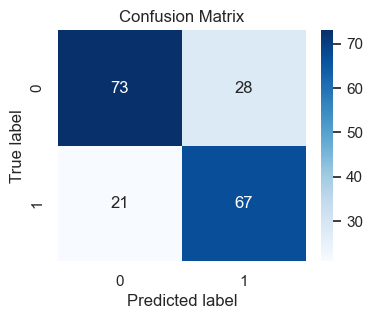

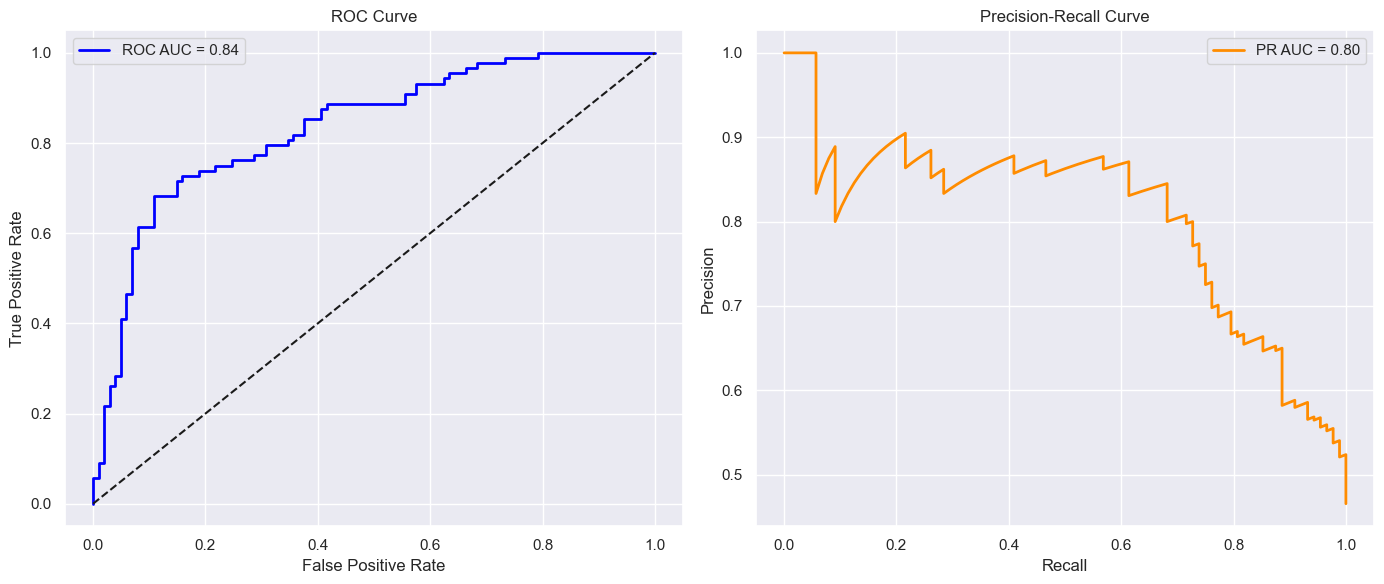

In [59]:
keras_clf = KerasClassifier(
    model=create_model,
    verbose=0,
    model__input_dim=X_train.shape[1],
    model__num_classes=num_classes,
    model__optimizer='adam',
    model__activation='tanh',
    model__hidden_layers=[100],
    batch_size=32,
    epochs=300,
    random_state=42
)

keras_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', keras_clf)
])
ovr = OneVsRestClassifier(keras_pipeline.named_steps['clf'])
ovr.fit(X_train, y_train)

y_pred_proba = ovr.predict_proba(X_test)

custom_preds = []
for probs in y_pred_proba:
    if probs[2] >= 0.25:        
        custom_preds.append(2)
    elif probs[1] >= 0.35:      
        custom_preds.append(1)
    else:
        custom_preds.append(0) 
        
y_pred_proba = y_pred_proba / y_pred_proba.sum(axis=1, keepdims=True)

calculate_evaluation_metrics(ovr, y_test, custom_preds, y_pred_proba)

for class_num, class_label in zip([2, 1, 0], ["all-star", "starter", "bench"]):
    df_bin = final_dataset_1_seasons.copy()
    df_bin[f'{class_label}_class'] = df_bin['Player_class_num'].apply(lambda x: 1 if x == class_num else 0)

    X_bin = df_bin.drop(columns=['Player_class_num', f'{class_label}_class'])
    y_bin = df_bin[f'{class_label}_class']

    X_train_bin, X_test_bin, y_train_bin, y_test_bin = train_test_split(
        X_bin, y_bin, test_size=0.2, random_state=42, stratify=y_bin)
    
    num_classes_bin = len(np.unique(y_train_bin))

    keras_clf_bin = KerasClassifier(
        model=create_model,
        verbose=0,
        input_dim=X_train_bin.shape[1],
        num_classes=num_classes_bin,
        optimizer='adam',
        activation='tanh',
        hidden_layers=[300],
        batch_size=32,
        epochs=100,
        random_state=42
    )

    keras_pipeline_bin = Pipeline([
        ('scaler', StandardScaler()),
        ('clf', keras_clf_bin)
    ])

    keras_pipeline_bin.fit(X_train_bin, y_train_bin)

    X_test_scaled_bin = keras_pipeline_bin.named_steps['scaler'].transform(X_test_bin)
    y_pred_proba_bin = keras_pipeline_bin.named_steps['clf'].predict_proba(X_test_scaled_bin)
    y_pred_bin = np.argmax(y_pred_proba_bin, axis=1)
    
    print(f"\nBinary classification results: {class_label} vs. others\n")
    calculate_evaluation_metrics(keras_pipeline_bin.named_steps['clf'].model_, y_test_bin, y_pred_bin, y_pred_proba_bin)

Number of elements in each class:
Player_class_num
0    351
1    300
2    102
Name: count, dtype: int64

Number of elements in each class after sampling:
Player_class_num
1    351
0    351
2    351
Name: count, dtype: int64

=== Classification Report ===
               precision    recall  f1-score   support

           0       0.68      0.74      0.71        88
           1       0.52      0.41      0.46        75
           2       0.39      0.50      0.44        26

    accuracy                           0.58       189
   macro avg       0.53      0.55      0.54       189
weighted avg       0.57      0.58      0.57       189


=== ROC AUC and PR AUC values ===
ROC AUC: 0.7519976801998688
PR AUC: 0.5814730069945498


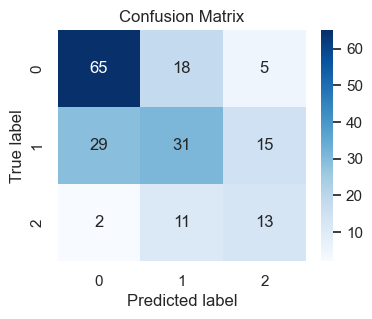

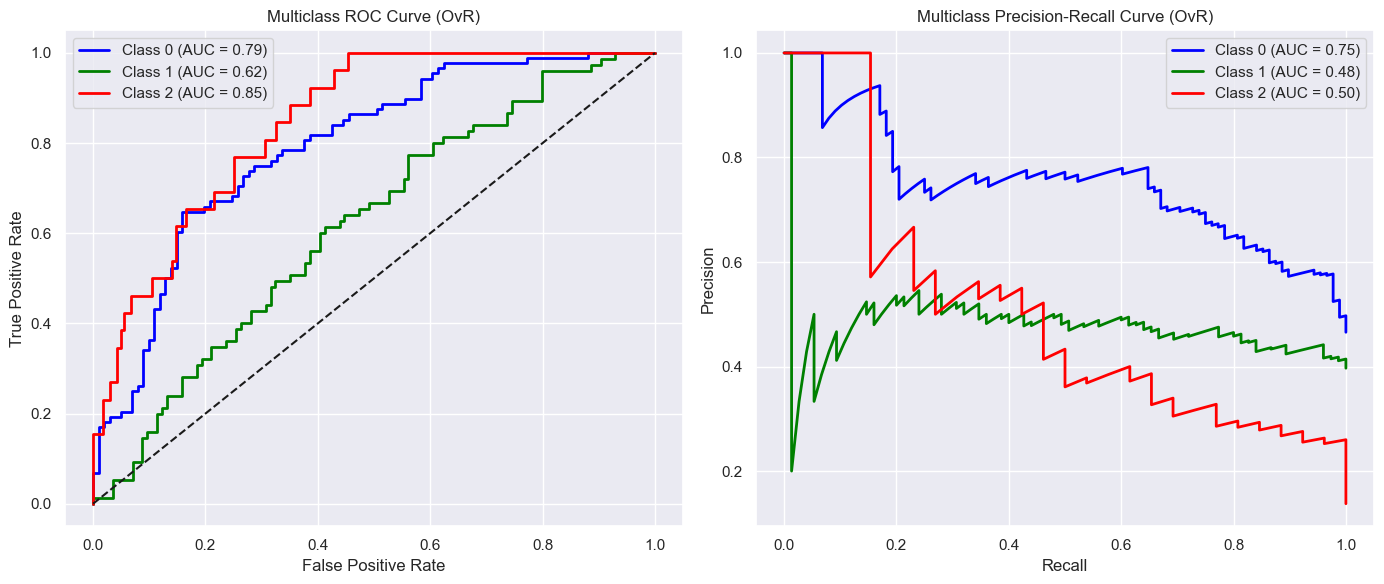

Number of elements in each class:
Player_class_num
0    351
1    300
2    102
Name: count, dtype: int64

Number of elements in each class after sampling:
all-star_class
0    651
1    651
Name: count, dtype: int64

Binary classification results: all-star vs. others


=== Classification Report ===
               precision    recall  f1-score   support

           0       0.93      0.83      0.88       163
           1       0.37      0.62      0.46        26

    accuracy                           0.80       189
   macro avg       0.65      0.72      0.67       189
weighted avg       0.85      0.80      0.82       189


=== ROC AUC and PR AUC values ===
ROC AUC: 0.7937706465313827
PR AUC: 0.470898951375258


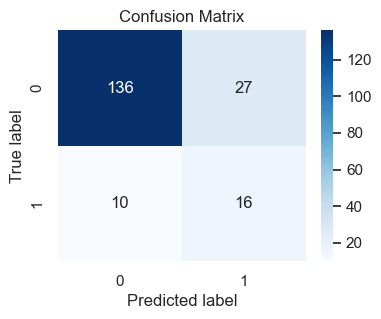

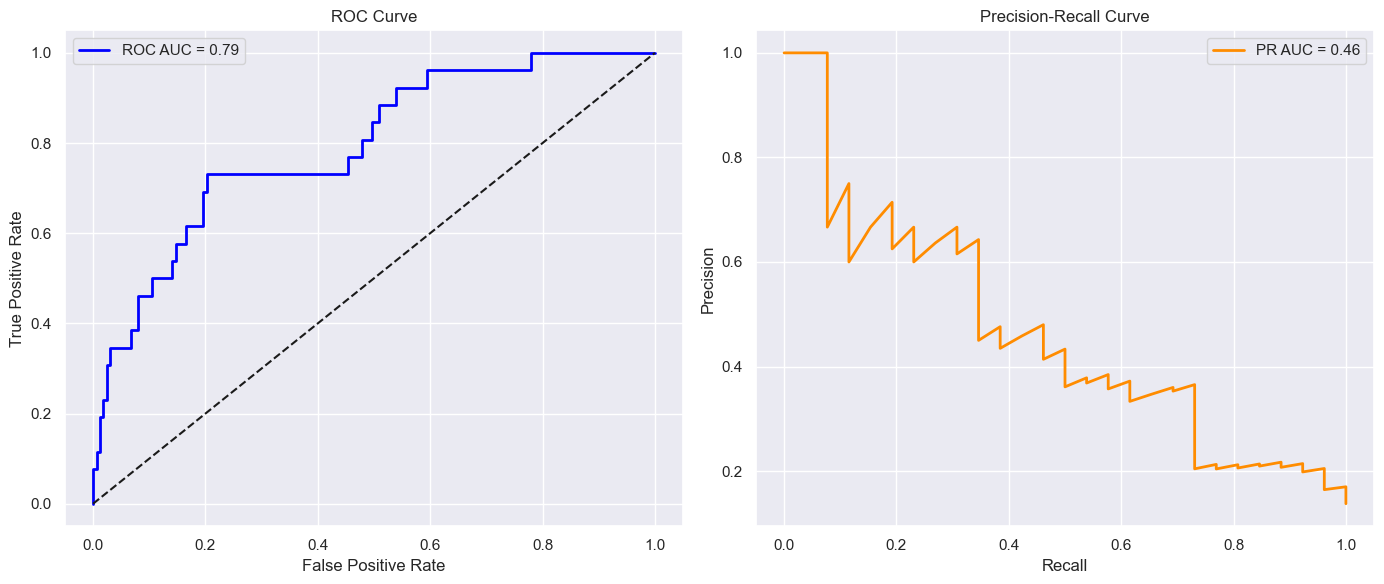

Number of elements in each class:
Player_class_num
0    351
1    300
2    102
Name: count, dtype: int64

Number of elements in each class after sampling:
starter_class
1    453
0    453
Name: count, dtype: int64

Binary classification results: starter vs. others


=== Classification Report ===
               precision    recall  f1-score   support

           0       0.69      0.66      0.68       114
           1       0.52      0.56      0.54        75

    accuracy                           0.62       189
   macro avg       0.61      0.61      0.61       189
weighted avg       0.62      0.62      0.62       189


=== ROC AUC and PR AUC values ===
ROC AUC: 0.6733333333333333
PR AUC: 0.5685745510010434


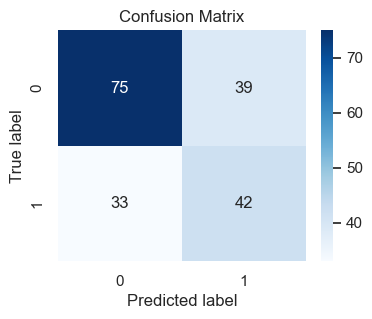

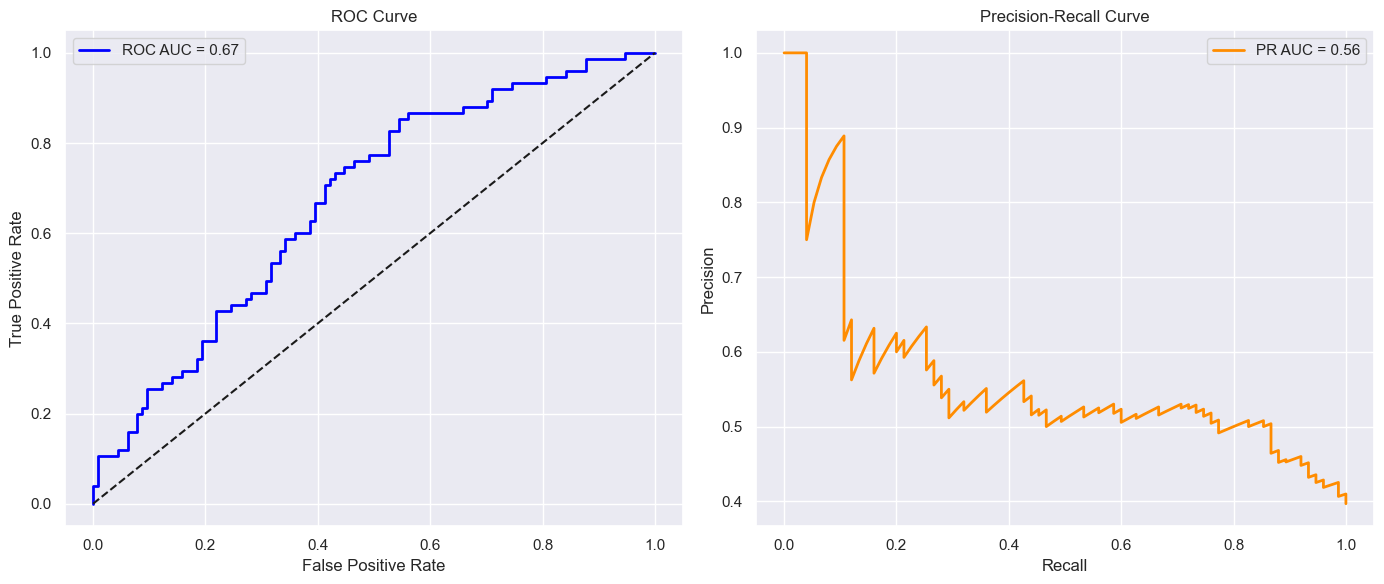

Number of elements in each class:
Player_class_num
0    351
1    300
2    102
Name: count, dtype: int64

Number of elements in each class after sampling:
bench_class
1    402
0    402
Name: count, dtype: int64

Binary classification results: bench vs. others


=== Classification Report ===
               precision    recall  f1-score   support

           0       0.79      0.65      0.71       101
           1       0.67      0.80      0.73        88

    accuracy                           0.72       189
   macro avg       0.73      0.72      0.72       189
weighted avg       0.73      0.72      0.72       189


=== ROC AUC and PR AUC values ===
ROC AUC: 0.8387713771377137
PR AUC: 0.8156442806023669


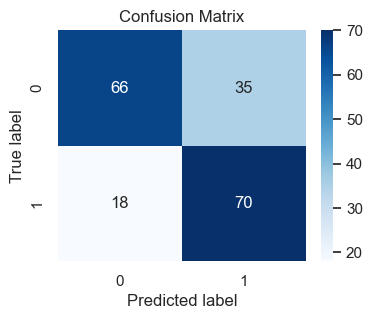

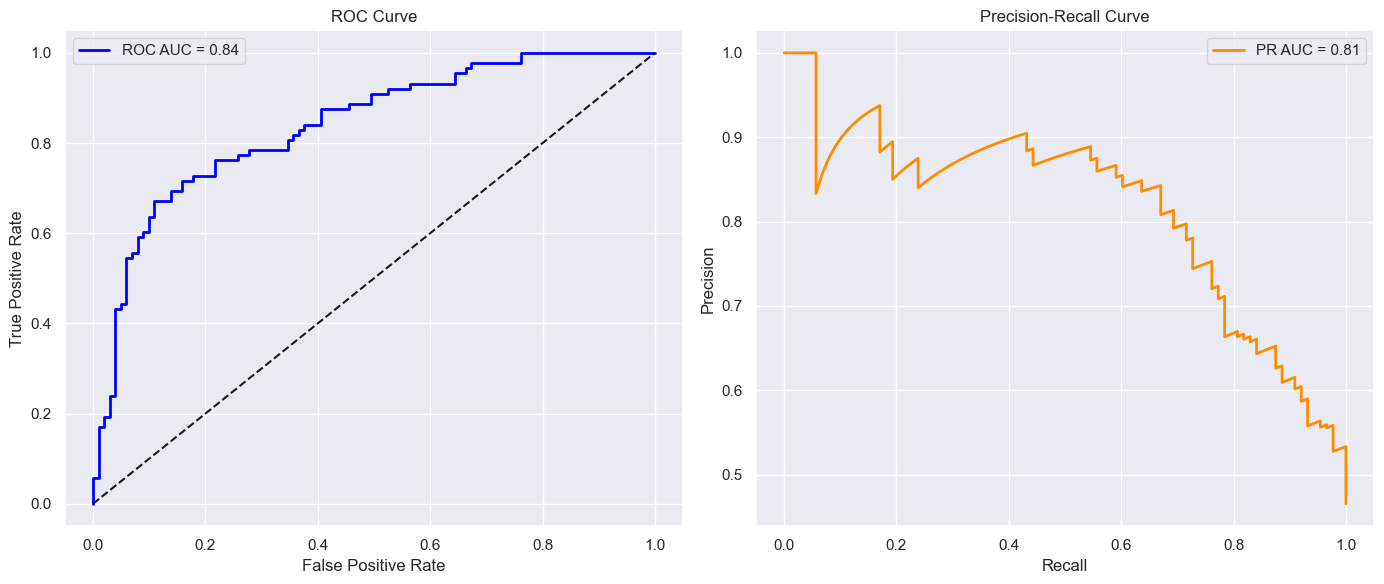

In [60]:
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X_train, y_train)

print('Number of elements in each class:')
print(y_train.value_counts())
print('\nNumber of elements in each class after sampling:')
print(pd.Series(y_res).value_counts())

num_classes = len(np.unique(y_res))

keras_clf = KerasClassifier(
    model=create_model,
    verbose=0,
    model__input_dim=X_res.shape[1],
    model__num_classes=num_classes,
    model__optimizer='adam',
    model__activation='tanh',
    model__hidden_layers=[300],
    batch_size=32,
    epochs=100,
    random_state=42
)

keras_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', keras_clf)
])

keras_pipeline.fit(X_res, y_res)

X_test_scaled = keras_pipeline.named_steps['scaler'].transform(X_test)
y_pred_proba = keras_pipeline.named_steps['clf'].predict_proba(X_test_scaled)
y_pred = np.argmax(y_pred_proba, axis=1)

calculate_evaluation_metrics(keras_pipeline.named_steps['clf'].model_, y_test, y_pred, y_pred_proba)

for class_num, class_label in zip([2, 1, 0], ["all-star", "starter", "bench"]):
    df_bin = final_dataset_1_seasons.copy()
    df_bin[f'{class_label}_class'] = df_bin['Player_class_num'].apply(lambda x: 1 if x == class_num else 0)

    X_bin = df_bin.drop(columns=['Player_class_num', f'{class_label}_class'])
    y_bin = df_bin[f'{class_label}_class']

    X_train_bin, X_test_bin, y_train_bin, y_test_bin = train_test_split(
        X_bin, y_bin, test_size=0.2, random_state=42, stratify=y_bin)
    
    smote = SMOTE(random_state=42)
    X_res_bin, y_res_bin = smote.fit_resample(X_train_bin, y_train_bin)

    print('Number of elements in each class:')
    print(y_train.value_counts())
    print('\nNumber of elements in each class after sampling:')
    print(pd.Series(y_res_bin).value_counts())
    
    num_classes_bin = len(np.unique(y_res_bin))

    keras_clf_bin = KerasClassifier(
        model=create_model,
        verbose=0,
        input_dim=X_train_bin.shape[1],
        num_classes=num_classes_bin,
        optimizer='adam',
        activation='tanh',
        hidden_layers=[300],
        batch_size=32,
        epochs=100,
        random_state=42
    )

    keras_pipeline_bin = Pipeline([
        ('scaler', StandardScaler()),
        ('clf', keras_clf_bin)
    ])

    keras_pipeline_bin.fit(X_res_bin, y_res_bin)

    X_test_scaled_bin = keras_pipeline_bin.named_steps['scaler'].transform(X_test_bin)
    y_pred_proba_bin = keras_pipeline_bin.named_steps['clf'].predict_proba(X_test_scaled_bin)
    y_pred_bin = np.argmax(y_pred_proba_bin, axis=1)
    
    print(f"\nBinary classification results: {class_label} vs. others\n")
    calculate_evaluation_metrics(keras_pipeline_bin.named_steps['clf'].model_, y_test_bin, y_pred_bin, y_pred_proba_bin)